# Introduction

Ce notebook est une version allégée de `Patin_Clement_1_notebook_052023.ipynb` pour la création d'une page web avec le package `Voilà!`.

L'objectif est de partager les résultats de la partie "gestion des valeurs manquantes" du nettoyage, ainsi que de la partie "exploration" d'une manière plus digeste.

In [60]:
# Nous allons tout d'abord importer les librairies utiles

In [1]:
import pandas as pd # to manipulate the dataset with dataframes
import numpy as np # for statistics and calculations

import matplotlib.pyplot as plt # for data visualisation
%matplotlib inline
import matplotlib.ticker as mtick # for format axis in percent %
import seaborn as sns # for data visualisation, with different proporties
import missingno as ms # for visualisation of missing data

from sklearn.preprocessing import MinMaxScaler, StandardScaler # for scaling

from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer # imputers

from sklearn.metrics import mean_squared_error, r2_score # measures for imputation quality

from sklearn.decomposition import PCA # PCA decomposition

import statsmodels.api as sm
from statsmodels.formula.api import ols # for ANOVA
import scipy.stats as stats

import ipywidgets as widgets

In [61]:
# Puis les .csv extraits du Notebook originel

In [2]:
# list of csv files names to import
importNamesList = [
    "foodClean08",
    "foodScaled",
    "foodIncomplete",
    "foodComplete",
    "errors",
    "foodCatImputed",
    "global5NN_measures",
    "globalIterImp_measures",
    "focusIterImp_measures",
    "foodImputed",
    "food"
]

In [3]:
# import each csv file and give it its name
for name in importNamesList :
    vars()[name]=pd.read_csv("df_exports/"+name+".csv",
                        sep='\t',
                        low_memory=False,
                        index_col=0
                       )

In [62]:
# Remettre les variables catégoriel sous le bon dtypes

In [4]:
categoricalColumnsNames=[
    "pnns_groups_1",
    "pnns_groups_2",
    "nutrition_grade_fr"
]
for df in [foodCatImputed,foodImputed,food] :
    df.loc[:,categoricalColumnsNames]=df[categoricalColumnsNames].astype("category")

In [63]:
# Charger les fonctions créées lors du travail sur le notebook originel

In [5]:
def dropEmptyCols(df,emptinessThreshold=1) :
    
    """return an input pandas.DataFrame without its empty columns
    
    inputs
    ------
    df : pandas.DataFrame object
    
    optional inputs 
    ---------------
    emptinessThreshold : float, default : = 1. Gives the limit threshold of emptiness. 
    if >=threshold, column is dropped. 
    
    returns
    -------
    dfWithoutEmptyCols : pandas.DataFrame object, the same one without its empty columns
    
    """
    #select columns with percentage of null values > threshold
    emptyColsNames=df.isna().mean().loc[df.isna().mean()>=emptinessThreshold].index 
    
    #drop selected columns
    dfWithoutEmptyCols=df.copy()
    dfWithoutEmptyCols = dfWithoutEmptyCols.drop(columns=emptyColsNames)
    
    return dfWithoutEmptyCols

In [6]:
def getCombiOfCol(listOfCols) :
    from itertools import combinations
    dictOfCombis = {}
    for n in range(len(listOfCols)) :
        listOfCombis=[]
        for combi in list(combinations(listOfCols,len(listOfCols)-n)) :
            listOfCombis.append(list(combi))
        dictOfCombis[len(listOfCols)-n]=listOfCombis
    return dictOfCombis

In [7]:
def myDescribe(df) :
    
    import ipywidgets as widgets # import library
  
    widDescribe=widgets.RadioButtons(options=["quantitative","qualitative","all"], 
                                     value="quantitative",
                                     description="Which features :",
                                     disabled=False,
                                    style={'description_width': 'initial'}
                                    )
    
    def describeFunct(df, whichTypes) :
        if whichTypes=="qualitative" :
            include=["O","category"]
            exclude=["float64","int64"]
        elif whichTypes=="quantitative" :
            include=None
            exclude=None
        elif whichTypes=="all" :
            include="all"
            exclude=None
        display(df.describe(include=include, exclude=exclude))
    
    out = widgets.interactive_output(describeFunct, {"df" : widgets.fixed(df),
                                                "whichTypes" : widDescribe ,
                                                               }
                                    )
    display(widDescribe,out)

In [8]:
def generateDfsToTestImput (df) :
    '''       
    Generate two dataframes to test missing values imputation techniques : 
    - one dataframe with all complete rows of the input dataframe
    - the same dataframe, but with artificial missing values    
    
    if imputaters are distance based, better to use an already scaled dataframe
    
    parameters
    ----------
    df : dataframe
        
    '''
    
    # create a dataframe with the non null rows of df

    dfComplete = df.copy() # create a copy
    dfComplete = dfComplete.loc[dfComplete.notna().all(axis=1)] # keep non null rows only 

    # create a second dataframe with null values
    
    # use a function to compute the combinations of the df's columns 
    combis=getCombiOfCol(df.columns.tolist())
    
    # create copys
    dfCompTransit = dfComplete.copy()
    dfTransit = df.copy()
    
    # list to store parts of futur incomplet dataframe
    dfIncompleteList =[]
    
    # first step - create a part with complet rows
    maskFull = df.notna().all(axis=1) # mask for complete rows of df
    fracFull = maskFull.mean() # % of complete rows in df
    
    dfTransit = dfTransit.loc[~maskFull] # exculde these complete rows from dfTransit
    
    filterFull = dfCompTransit.sample(frac=fracFull,random_state=0) # create a sample of dfCompTransit with the same proportion
    dfIncompleteList.append(filterFull) # add this complete part to the list
    
    idxFull = filterFull.index # store index
    dfCompTransit = dfCompTransit.loc[~dfCompTransit.index.isin(idxFull)] # exclude these rows of dfCompTransit
    
    # then - iterate on combinations of columns to create missing values
    for i,listOfcombis in enumerate(combis.values()) :
        for j,combi in enumerate(listOfcombis) :

            maskDf=dfTransit[combi].isna().all(axis=1) # mask of empty rows for this combination in dfTransit
            fracCombiDf=maskDf.mean() # proportion

            dfTransit=dfTransit.loc[~maskDf] # exclude these empty rows from dfTransit
            
            combiFilter=dfCompTransit.sample(frac=fracCombiDf,random_state=100*(i+1)+10*(j+1)) # create a sample with the same proportion
            combiFilter[combi]=np.nan # fill this sample with NaNs for columns of combi
            dfIncompleteList.append(combiFilter) # add this part to the list
            indCombi=combiFilter.index # store the index
            dfCompTransit=dfCompTransit.loc[~dfCompTransit.index.isin(indCombi)] # exclude these rows from dfCompTransit
            if len(dfCompTransit) == 0 : # stop if dfCompTransit is empty
                break
    
    # create dfIncomplete from the list
    dfIncomplete = pd.concat(dfIncompleteList).sort_index()
    
    return dfComplete , dfIncomplete

In [9]:
def myKNNCategoricalImputer (df,catCol,k) :
    
    '''       
    from a given dataframe and a given categorical feature name, 
    returns the same dataframe with the categorical feature missing values imputed.
    
    Imputation porcess uses the KNN classifier from scikit learn.
    
    
    
    parameters
    ----------
    df : dataframe
    catCol : string, name of the categorcial feature
    k : int, hyperparameter for knn classifier
    
    return
    ------
    resultDf : same dataframe, with catCol missing values imputed
    
    '''
    
    # import library
    from sklearn import neighbors
    
    # create a copy
    workDf=df.copy()
    
    # if not, set catCol feature dtype to "category"
    workDf.loc[:,catCol]=workDf[catCol].astype("category")
    
    # store catCol mode
    modeCatCol = workDf[catCol].mode()[0]
    
    # split workDf into "train" and "to imputed" dataframes
    workDfTrain = workDf.loc[workDf[catCol].notna()]
    workDfToImp = workDf.loc[workDf[catCol].isna()]

    # store the numerical features names in a list, for knn algo
    knnCols = [col for col in workDfTrain.select_dtypes("float64").columns.tolist()]
    
    # use getCombiOfCol function to create a dictionnary of all numerical columns combinations
    combisKnnCols = getCombiOfCol(knnCols)
    
    # create the output dataframe
    resultDf=workDf.copy()
    
    # imputation 
    # itirate on lists of columns combinations :
    for n,listOfCombi in combisKnnCols.items() : # for each list of list of columns with a lenght of n elements

        for ColList in listOfCombi : # for each columns combination
            workDfToImpColList = workDfToImp.loc[workDfToImp[ColList].notna().all(axis=1)] # filter on rows with all features values completed

            if len(workDfToImpColList)==0 :
                continue # if no observations in this filtered dataframe, continue
                
            idxToImpColList = workDfToImpColList.index # store index

            workDfTrainColList = workDfTrain.loc[workDfTrain[ColList].notna().all(axis=1)] # filter the same way on the train df

            if len(workDfTrainColList)>=k : # if the number of neighbors in workDfTrainColList is equal or above to our given k
                knnColList = neighbors.KNeighborsClassifier(n_neighbors=k) # intanciate  knn classifier
                knnColList.fit(workDfTrainColList[ColList],workDfTrainColList[catCol]) # train it on our filtered train set

                imputationsColList=knnColList.predict(workDfToImpColList[ColList]) # predict catCol values on our "to imput" filtred df

            else : # if the number of neighbors is below k
                imputationsColList=workDfToImpColList[catCol].fillna(value=modeCatCol).values # we fill with the mode

            resultDf.loc[idxToImpColList,catCol]=imputationsColList # put results on resultDf

            workDfTrain = resultDf.loc[resultDf[catCol].notna()] # remove rows from workDfTrain
            workDfToImp = resultDf.loc[resultDf[catCol].isna()] # remove rows from workDfToImp

            if len(workDfToImp) == 0 :
                break # break if workDfToImp is empty
    return resultDf

In [10]:
def BestKforMyKNNCatImputer(dfComplete, dfIncomplete, catCol, rangeOfK=(2,10)) :
    
    ''' 
    generate a 2 columns dataframe with r2 and Root Mean Squared Error for each numerical feature
    
    
    parameters
    ----------
    dfComplete : dataframe only with no missing values
    dfIncomplete : same dataframe, with missing values
    catCol : name of the categorical columns to imput
    
    optional parameters
    -------------------
    rangeOfK : tuple, interval of Ks to test on
    
    returns
    -------
    resultTabPercentError : dataframe with
        Ks in index 
        a column with the percentage of errors
    '''
        
    
    # create dataframe to store the mesure for each k
    resultTabPercentError=pd.DataFrame(columns=["%Error_"+catCol])
       
    # for each K, run the myKNNCategoricalImputer function on catCol
    for K in range(rangeOfK[0],rangeOfK[1]+1) :
                      
        # generate a seriesImput for catCol
        dfImput=myKNNCategoricalImputer(dfIncomplete,catCol,k=K)
        seriesImput=dfImput.loc[dfIncomplete[catCol].isna(),catCol]

        seriesSoluce=dfComplete.loc[dfIncomplete[catCol].isna(),catCol] # the real values for catCol
       
        # put in the main tab
        resultTabPercentError.loc["k="+str(K)]=(seriesImput!=seriesSoluce).mean()

  
    return resultTabPercentError

In [11]:
# function to get in a dataframe the results of imputation for a specific feature

def getSoluceColAndGuessCol (col, dfComplete, dfIncomplete, dfImput) :
    
    ''' 
    generate a 2 columns dataframe with the results of imputation for a specific feature
    
    
    parameters
    ----------
    col : string, feature's name
    dfComplete : dataframe only with no missing values
    dfIncomplete : same dataframe, with missing values
    dfImput : same dataframe, with the missing values imputed
    
    returns
    -------
    SoluceAndGuessTab : dataframe with
        only original missing values indexes, 
        a column of expected values 
        a columns of imputed values
    '''
    
    # get missing values index
    colNanIndex = dfIncomplete.loc[dfIncomplete[col].isna()].index # get nan values index
    
    # create tab
    SoluceAndGuessTab = pd.DataFrame() # initiate dataframe
    SoluceAndGuessTab[col+"_SOLUCE"]=dfComplete.loc[colNanIndex,col] # create expected values column
    SoluceAndGuessTab[col+"_IMPUT"]=dfImput.loc[colNanIndex,col] # create imputed values column
    
    return SoluceAndGuessTab

In [12]:
def resultsNumImput(dfComplete, dfIncomplete, dfImput) :
    
    ''' 
    generate a 2 columns dataframe with r2 and Root Mean Squared Error for each numerical feature
    
    
    parameters
    ----------
    dfComplete : dataframe only with no missing values
    dfIncomplete : same dataframe, with missing values
    dfImput : same dataframe, with the missing values imputed
       
    returns
    -------
    resultTab : dataframe with
        numerical features in index 
        a column with RMSE 
        a column with R2
    '''
        
    # list of numerical features
    numFeaturesNames = dfComplete.select_dtypes("float64").columns.tolist()
      
    # initiate tab
    resultTab = pd.DataFrame(columns=['RMSE','R2'],index=numFeaturesNames,dtype="float64")
    
    # compute RMSE and R2 for each column
    for col in numFeaturesNames :
        
        colNanIndex = dfIncomplete.loc[dfIncomplete[col].isna()].index # get nan values index
        
        # get the columns
        soluceCol = dfComplete.loc[colNanIndex,col]
        imputCol  = dfImput.loc[colNanIndex,col]
        
        # compute RMSE and R2, and put them in tab
        RMSECol = np.sqrt(mean_squared_error(soluceCol,imputCol))
        resultTab['RMSE'].loc[col]=RMSECol
        
        R2Col = r2_score(soluceCol,imputCol)
        resultTab['R2'].loc[col]=R2Col
        
    return resultTab

In [13]:
def BestKNNImputer(dfComplete, dfIncomplete, rangeOfK=(2,10)) :
    
    ''' 
    generate a 2 columns dataframe with r2 and Root Mean Squared Error for each numerical feature
    
    
    parameters
    ----------
    dfComplete : dataframe only with no missing values
    dfIncomplete : same dataframe, with missing values
    dfGuess : same dataframe, with the missing values imputed
    
    optional parameters
    -------------------
    nameOfTest : string, name of the imputation test
    
    returns
    -------
    resultTab : dataframe with
        numerical features in index 
        a column with RMSE 
        a column with R2
    '''
    
    # list of numerical features
    numFeaturesNames = dfComplete.select_dtypes("float64").columns.tolist()
    
    # create dataframes to store the mesures for each k
    resultTabRMSE=pd.DataFrame(index=numFeaturesNames,dtype="float64")
    resultTabR2=pd.DataFrame(index=numFeaturesNames,dtype="float64")
    
    # create a dataframe to store the mean of RMSEs and the mean of R2s for each k
    resultTabGlobal=pd.DataFrame(columns=["k="+str(i) for i in range(rangeOfK[0],rangeOfK[1]+1)], 
                                 index=["Mean_of_RMSEs","Mean_of_R2s"],dtype="float64")
    
    for k in range(rangeOfK[0],rangeOfK[1]+1) :
        
        KNN_imputer=KNNImputer(n_neighbors=k,missing_values=np.nan) # initiate knn imputer for this k
        
        # generate a dfGuess
        dfImputK=pd.DataFrame(
            KNN_imputer.fit_transform(dfIncomplete[numFeaturesNames]), # fit transform
            columns=numFeaturesNames,
            index=dfIncomplete.index
        )
        
        # use previous function and generate a resultsNumImput(dfComplete, dfIncomplete, dfImput) :
        resultTabK=resultsNumImput(
            dfComplete=dfComplete, 
            dfIncomplete=dfIncomplete, 
            dfImput=dfImputK, 
        )
        
        # put in the main tabs
        resultTabRMSE["RMSE"+"_"+"k="+str(k)]=resultTabK["RMSE"]
        resultTabR2["R2"+"_"+"k="+str(k)]=resultTabK["R2"]
        
       
        resultTabGlobal["k="+str(k)].loc["Mean_of_RMSEs"]=resultTabK["RMSE"].mean()
        resultTabGlobal["k="+str(k)].loc["Mean_of_R2s"]=resultTabK["R2"].mean()
    
    # give for each numerical feature the k with best RMSE and R2
    resultTabRMSE["best_k_per_feature"]=resultTabRMSE.idxmin(axis=1).str.split("=").str[-1]
    resultTabR2["best_k_per_feature"]=resultTabR2.idxmax(axis=1).str.split("=").str[-1]
    
    # give, globally, for Mean_of_RMSEs and for Mean_of_R2s, the best k
    resultTabGlobal.loc["Mean_of_RMSEs","best_k_on_average"]=resultTabGlobal.loc["Mean_of_RMSEs"].idxmin(axis=0).split("=")[-1]
    resultTabGlobal.loc["Mean_of_R2s","best_k_on_average"]=resultTabGlobal.loc["Mean_of_R2s"].astype("float64").idxmax(axis=0).split("=")[-1]
  
    return resultTabRMSE,resultTabR2,resultTabGlobal

In [14]:
def ShowResultsNumImputsSolo (measuresTabs,
                              testName,
                              measureType,
                              testsNamesList=None,
                              dictPalette=None,
                              figsize=(8,6)
                             ) :

    '''draw 1 barplot  of numerical features imputation test results : RMSE or R2

    parameters
    ----------
    measuresTabs : dataframe or list of df, output of the resultsNumImput() function
    testName : string , name of the imputation test
    measureType : string, type of imputation perf measure - "RMSE" or "R2"

    optionnal
    ---------
    testsNamesList : list of tests names
    dictPalette : dictionnary, with features names for keys and colors for values
    figsize : tuple or list, dimensions of the figure
        
    returns
    -------
    a barplot : RMSE or R2, for each feature
    '''
        
    # visualisation of imputation result for a specific test and a specific measure
    sns.set_theme()
    # convert measuresTabs and testNames if not lists
    if type(measuresTabs)!=list :
        measuresTabs=[measuresTabs]
    if testsNamesList and type(testsNamesList)!=list :
        testsNamesList=[testsNamesList]
    # select tab from measuresTabs
    if testsNamesList :
        tab=measuresTabs[testsNamesList.index(testName)]
    else :
        tab=measuresTabs[0]

    # set main parameters for the visualisation
    sns.set_theme()
    fig,axs=plt.subplots(1, 
                         figsize=figsize,
                         ) 
    fig.suptitle("Résultats des tests d'imputation avec "+testName+" - valeurs de "+measureType,fontsize=12) 
    xlabels=[col for col in measuresTabs[0].index] # set labels : features names

    
    # create barplot
        
    axs.bar(x=[1+k for k in range(len(xlabels))], # one bar for each feature
            height=tab[measureType], # the measure value
            width=0.7,
            color=[dictPalette[col] 
                   if dictPalette 
                   else "r" 
                   for col in xlabels], # if each feature has a specific color, we use it
            ec="k", # black bar edges 
            alpha=1
           )

    axs.set_xlim(0,len(xlabels)+1) # set x axis min and max
    axs.set_xticks([k+1 for k in range(len(xlabels))]) # set positions of ticks
    axs.set_xticklabels(xlabels,rotation=45,ha="right") # features names for ticklabels
    axs.set_ylabel(measureType)
    if measureType=="RMSE" :
        axs.set_ylim(bottom=0,top = max([tab["RMSE"].max() for tab in measuresTabs])*1.1) # set y axis min max for RMSE barplot
    if measureType=="R2" :
        axs.set_ylim(bottom=0,top=1) # set y axis min for R2 bar plot
    
    plt.show()

In [15]:
def ShowResultsNumImputsWID (measuresTabs,testsNamesList,dictPalette=None,figsize=(6,5)) :

    '''draw 1 barplot  of numerical features imputation test results : RMSE or R2

    parameters
    ----------
    measuresTabs : dataframe or list of df, output of the resultsNumImput() function
    testsNamesList : list of tests names (can be a string if only one test)

    optionnal
    ---------
    dictPalette : dictionnary, with features names for keys and colors for values
    figsize : tuple or list, dimensions of the figure
        
    returns
    -------
    a barplot : with RadioButtons to select :
        - a test
        - a measure type (RMSE or R2)
    '''
    
    # convert measuresTabs and testNames if not lists
    if type(measuresTabs)!=list :
        measuresTabs=[measuresTabs]
    if type(testsNamesList)!=list :
        testsNamesList=[testsNamesList]

    
    # create ipywidgets RadioButtons
    import ipywidgets as widgets # import library
    
    
    widMeasure=widgets.RadioButtons(options=measuresTabs[0].columns, 
                                     value=measuresTabs[0].columns[0],
                                     description="Performance measure :",
                                     disabled=False,
                                    style={'description_width': 'initial'}
                                    )
    
    widTest=widgets.RadioButtons(options=testsNamesList,
                                     value=testsNamesList[-1],
                                     description="Imputation test :",
                                     disabled=False,
                                 style={'description_width': 'initial'}
                                    )

    ui=widgets.HBox([widTest,widMeasure]) # horizontal user interface 
    
    # use defined widgets on ShowResultsNumImputsSolo()
    out = widgets.interactive_output(ShowResultsNumImputsSolo, {"measuresTabs" : widgets.fixed(measuresTabs),
                                                                "testName" : widTest ,
                                                                "measureType" : widMeasure,
                                                                "testsNamesList" : widgets.fixed(testsNamesList),
                                                                "dictPalette" : widgets.fixed(dictPalette),
                                                                "figsize":widgets.fixed(figsize)
                                                               }
                                    )
    
    display(ui,out)


In [16]:
def ShowResultsNumImputsMulti (measuresTabs,testsNamesList,dictPalette=None) :

    # visualisation of imputation tests measures

    '''draw barplots  of numerical features imputation tests results (one for RMSE, one for R2)

    parameters
    ----------
    measuresTabs : dataframe or list of dataframes, output(s) of the resultsNumImput function
    testsNamesList : string or list of strings, name(s) of the imputation test(s)
    
    optionnal
    ---------
    dictPalette : dictionnary, with features names for keys and colors for values
        
    returns
    -------
    a figure with 2 or 3 axes
        - 2 barplots : one for RMSE and one for R2
        - if several tests results, draw a legend on the 3rd axe
    '''
    
    # convert measuresTabs and testsNamesList if not lists
    if type(measuresTabs)!=list :
        measuresTabs=[measuresTabs]
    if len(measuresTabs)==1 :
        several=0 # store the information, we have only one test
    else :
        several=1 # store the information, we have several tests, we will need a legend
    if type(testsNamesList)!=list :
        testsNamesList=[testsNamesList]

    
    # store  the number of different tests
    m=len(measuresTabs[0].columns)

    # set main parameters for the visualisation
    sns.set_theme()
    fig,axs=plt.subplots(1,m+several, # an additionnal axe if we need to create a legend
                         figsize=(16,8),
                         gridspec_kw={'width_ratios': [3 if k!=m else 1 for k in range(m+several)]} # if a legend, smaller
                        ) 
    if several==0 : # if we have only one test, we can put its name in the main title
        fig.suptitle("Résultats des tests d'imputation avec "+testsNamesList[0],fontsize=20) 
    else : # if we have several tests, the different names will be in the legend
        fig.suptitle("Résultats des tests d'imputation avec chaque méthode",fontsize=20)
    xlabels=[col for col in measuresTabs[0].index] # set labels : features names

    # set width of the bars
    l = len(measuresTabs)
    myWidth = 0.7/l
    # create an offset for each bar
    xOffset = 1-(l-1)*myWidth/2

    # create barplots for RMSE and R2
    for i,tab in enumerate(measuresTabs) : # we iterate on tests
        for j,measure in enumerate(tab.columns) : # we iterate on measures

            axs[j].bar(x=[k+xOffset+i*myWidth for k in range(len(xlabels))], # one bar for each feature
                       height=tab[measure], # the measure value
                       width=myWidth,
                       color=[dictPalette[col] 
                              if dictPalette 
                              else "r" 
                              for col in xlabels], # if each feature has a specific color, we use it
                       ec="k", # black bar edges 
                       alpha=(i+1)/l
                      )

            axs[j].set_xlim(0,len(xlabels)+1) # set x axis min and max
            axs[j].set_xticks([k+1 for k in range(len(xlabels))]) # set positions of ticks
            axs[j].set_xticklabels(xlabels,rotation=45,ha="right") # features names for ticklabels
            axs[j].set_title("Mesure de performance - "+measure,fontsize=15,fontweight="heavy") # name of measure for axe title
    

    # create a legend if several=1
        if several==1 :
            # we create a bar for each test
            axs[-1].bar(x=xOffset+i*myWidth,
                            height=1,
                            width=myWidth,
                            color="grey",
                            ec="k",
                            alpha=(i+1)/l
                           )
            # we put each test name in its bar
            axs[-1].text(x=xOffset+i*myWidth,
                         y=1,
                         s=testsNamesList[i],
                         fontsize=25/m,
                         color="k",
                         rotation="vertical",
                         ha="center",
                         va="top"
                         )
            axs[-1].set_xlim(0.25,1.75) # set x axis min and max
            axs[-1].set_ylim(0,1.1) # set y axis min and max
            axs[-1].set_xticklabels("") # ne need for labels
            axs[-1].set_yticklabels("")
            axs[-1].set_title("Legend",fontsize=12,style="italic") # put "legend" in title
            axs[-1].set_facecolor((1, 1, 1)) # no need for grid
            axs[-1].spines[["left", "right", "top", "bottom"]].set_color("k") # just need for the "box"

    axs[0].set_ylim(bottom=0,top = max([tab["RMSE"].max() for tab in measuresTabs])*1.1) # set y axis min max for RMSE barplot
    axs[1].set_ylim(bottom=0,top=1) # set y axis min for R2 bar plot
    
    plt.show()

In [17]:
def ShowResultsNumImputsCHOICES (measuresTabs,testsNamesList,dictPalette=None,singleFigsize=(6,5)) :

    '''draw barplots  of numerical features imputation tests results (one for RMSE, one for R2)

    parameters
    ----------
    measuresTabs : list of dataframes, output(s) of the resultsNumImput function
    testNames : list of strings, name(s) of the imputation test(s)

    optionnal
    ---------
    dictPalette : dictionnary, with features names for keys and colors for values
    returns
    -------
    resultTab : a figure with 2 or 3 axes
        - 2 barplots : one for RMSE and one for R2
        - if several tests results, draw a legend on the 3rd axe
    '''
    

    # create ipywidgets dropdowns
    import ipywidgets as widgets
    
    
    widGraph=widgets.RadioButtons(options=["Multi - All tests and measures","Single - One test and one measure"],
                                     value="Single - One test and one measure",
                                     description="",
                                     disabled=False,
                                    style={'description_width': 'initial'}
                                    )
    ui=widgets.HBox([widgets.Label("Plotting option :"),widGraph])
    
    def witchGraphFunc(graphType) :
        if graphType == "Multi - All tests and measures" :
            ShowResultsNumImputsMulti (measuresTabs=measuresTabs,testsNamesList=testsNamesList,dictPalette=dictPalette)
        if graphType == "Single - One test and one measure" :
            ShowResultsNumImputsWID (measuresTabs=measuresTabs,testsNamesList=testsNamesList,dictPalette=dictPalette,figsize=singleFigsize)
    
    out = widgets.interactive_output(witchGraphFunc, {"graphType" : widGraph})
    
    display(ui,out)
    


In [18]:
def makeCorrGroups(df, threshold) :
    '''
    A function to make groups of columns based on correlation of one member to another
    
    parameters
    ----------
    df : dataframe
    threshold : float in [0,1], correlation threshold
    
    returns
    -------
    groupsDict : dictionnary with groups, each with the list of features
    '''
    # compute correlation matrix
    corrMatrix = df.corr()
    
    # Generate a mask to keep only the lower triangle
    maskTri = np.triu(np.ones_like(foodCorr, dtype=bool),k=0)
    
    # apply to the matrix
    corrMatrix = corrMatrix.mask(maskTri)
    
    # create a group if there is at least one value > threshold in a column
    
    # put first member of the group in a list
    groupsFirstMembers = [col for col in corrMatrix.columns if any(np.abs(corrMatrix[col])>=threshold)]
    # initiate a dictionnary
    groupsDict = {i : [groupsFirstMembers[i]] for i in range(len(groupsFirstMembers))}
    # complete each group
    for G in groupsDict.keys() :
        for col in corrMatrix.columns :
            if np.abs(corrMatrix.loc[col,groupsDict[G][0]])>=threshold :
                groupsDict[G].append(col)
    
    # drop group if all feature are already in another one
    keysToDrop = set()
    for Gi in groupsDict.keys() :
        for Gj in groupsDict.keys() :
            if Gi==Gj : # iterate on the other groups
                continue
            if all(col in groupsDict[Gi] for col in groupsDict[Gj]) : # check if all feature of Gj are in Gi
                keysToDrop.add(Gj)
    
    for G in keysToDrop :
        groupsDict.pop(G) # drop selected groups
    
    # rename groups
    groupsDict = {"G"+str(list(groupsDict.keys()).index(k)+1) : G for k,G in groupsDict.items()}
    
    # put not correlated feature in a last group
    groupsDict["others"] = [col for col in corrMatrix.columns if col not in sum(groupsDict.values(),[]) ]
    
    return groupsDict

In [19]:
def featureDistrib(df,featureName,dictPalette=None,ax=None) :
    '''
    A function to draw the empirical distribution of a given feature
    
    parameters
    ----------
    df : dataframe
    
    optionnal
    ---------
    dictPalette : dictionnary, with features names for keys and colors for values. By default None
    ax = axe position, if used within a matplotlib subplots
    

    '''
    
    # common parameters
    sns.set_theme()
    myColor=dictPalette[featureName] if dictPalette else None # set the color of graph with dictPalette
    myStat="density" # graph will display percentages
    
    if df[featureName].dtype in ["float64","int64"] : # for numerical features
        sns.histplot(data=df,
                     x=featureName,
                     color=myColor,
                     kde=True, # show density estimate
                     ax=ax,
                     stat=myStat,
                    ) # draw
    else : # for other categorical features
        myOrder=df[featureName].value_counts().index.tolist() # sort feature categories by number of appearence
        myOrderedCatSeries=pd.Categorical(df[featureName],myOrder) # create a categorical Series with that order
        sns.histplot(y=myOrderedCatSeries,
                     color=myColor,
                     ax=ax,
                     stat=myStat

                   )
    # set title if ax=None
    if not ax :
        plt.title(featureName+" - Distribution empirique");

In [20]:
def compareFeatureDistrib (newDf,oldDf,featureName,dictPalette=None,figsize=(15,6)) :
    '''
    A function to compare the empirical distribution of a given feature, before and after imputations
    
    parameters
    ----------
    newDf : dataframe with imputed feature
    oldDf : dataframe with non-imputed feature
    featureName : name of the feature
    
    optionnal
    ---------
    dictPalette : dictionnary, with features names for keys and colors for values. By default None
    figsize : tuple or list, dimensions of the figure. By default (15,6)
    

    '''
    sns.set_theme()
    fig,axs=plt.subplots(1,2,figsize=figsize,sharex=True,sharey=True) # create a 2 axes subplots
    fig.suptitle("Impact des imputations sur la distribution empirique de "+featureName) # set title
    featureDistrib(oldDf,featureName,dictPalette,ax=axs[0]) # use featureDistrib() on non-imputed version
    featureDistrib(newDf,featureName,dictPalette,ax=axs[1]) # use featureDistrib() on imputed version

    
    # set subtitles
    axs[0].set_title("sans Imputation")
    axs[1].set_title("avec Imputation");
    

In [21]:
def compareDfDistribs (newDf,oldDf,colList,dictPalette=None,figsize=(15,6)) :
    '''
    A function to compare the empirical distribution of any of a given features list, before and after imputations
    
    parameters
    ----------
    newDf : dataframe with imputed feature
    oldDf : dataframe with non-imputed feature
    colList : list of features
    
    optionnal
    ---------
    dictPalette : dictionnary, with features names for keys and colors for values. By default None
    figsize : tuple or list, dimensions of the figure. By default (15,6)
    

    '''
    # 


    import ipywidgets as widgets
    widFeature=widgets.Dropdown(options=colList,
                                              description="Feature :",
                                              disabled=False,
                                              style={'description_width': 'initial'}
                                             )
    
    out = widgets.interactive_output(compareFeatureDistrib, {"newDf" : widgets.fixed(newDf),
                                                             "oldDf" : widgets.fixed(oldDf),
                                                             "featureName" : widFeature ,
                                                             "dictPalette" : widgets.fixed(dictPalette),
                                                             "figsize":widgets.fixed(figsize)
                                                               }
                                    )
    display(widFeature,out)

In [22]:
def distribRidgePlot(df, categFeatureName, numFeatureName,palette=None,overlap=0.5,order=None,zoomInterval=None,clip=None) :
    '''
    A function to compare the empirical distribution of any of a given features list, before and after imputations
    
    parameters
    ----------
    newDf : dataframe with imputed feature
    oldDf : dataframe with non-imputed feature
    colList : list of features
    
    optionnal
    ---------
    palette : dictionnary, with features names for keys and colors for values. By default None
    overlap : float, to adjust space between facets/axes. Default = 0.5
    order : list of labels of the categorical feature, in a given order
    zoomInterval : tuple or list, zoom interval on x axis. By default None
    clip : tuple or list, kdeplot interval
    

    '''
    # set theme
    sns.set_theme(
        style="white", # seaborn white style
        rc={"axes.facecolor": (0, 0, 0, 0), # set facecolor with alpha = 0, so the background is transparent
            'axes.linewidth':2} # thick line width
    )
    
    # config the order of categories on the grid
    if order :
        myRowOrder = order
    else :
        myRowOrder = df.groupby(categFeatureName)[numFeatureName].median().sort_values(ascending=False).index.tolist()
    
    # config palette
    nbLabels=df[categFeatureName].nunique()
    if palette :
        if type(palette)==dict :
            myPalette=palette
        elif type(palette)==str :
            myPalette={lab : c for lab,c in zip(myRowOrder,sns.color_palette(palette,n_colors=nbLabels))}
        else :
            myPalette={lab : c for lab,c in zip(myRowOrder,sns.color_palette(n_colors=nbLabels))}
    else :
        myPalette={lab : c for lab,c in zip(myRowOrder,sns.color_palette(n_colors=nbLabels))}
    
    # initiate a FacetGrid object
    g = sns.FacetGrid(
        data=df, 
        row=categFeatureName, # create one subplot for each category of feature
        hue=categFeatureName, # use a different color plot for each subplot
        palette=myPalette, # use given palette
        row_order=myRowOrder, # order the categories/levels
        height=1.2, # height of each facet
        aspect=9 # height ratio to give the width of each facet
        
    )
    
    # draw density plots
    # ones filled with a color
    g.map_dataframe( # apply plotting function to each facet
        sns.kdeplot, # density function
        x=numFeatureName, # use with our numerical feature
        fill=True, # fill area under plot
        alpha=1,
        clip=clip
    )
    # ones with only a black line
    g.map_dataframe(
        sns.kdeplot,
        x=numFeatureName,
        color="black",
        clip=clip
    )
    
    # set main title
    plt.suptitle("Distibution de '"+numFeatureName+"' en fonction de '"+categFeatureName+"'")
    
    # set facets titles
    # plots will overlap so we need to place titles in an unusual place
    def writeCategory(x, color, label): # create a plotting function to write titles
        ax = plt.gca() # get current axes
        ax.text(x=0, # left of the distribution plot
                y=0.05/overlap, # above x axis line
                s=label, # write current category/label of categFeatureName of the facet
                color=color, # use the current color of the facet
                fontsize=10, # def texte size
                ha="left", va="center", # vertical and horizontal alignments
                transform=ax.transAxes  # use coordinate system of the Axes
               )
    g.map(writeCategory, numFeatureName) # draw our titles on each facet
    g.set_titles("") # get rid of classic facet titles
    
    # make plots overlap
    g.fig.subplots_adjust(hspace=-overlap)

    # set ticks and ticklabels
    g.set(ylabel="", # we do not need the y label (always the same)
          yticks=[], # focus on shape, no need for y ticks
          xlabel=numFeatureName, # set x label
          xlim=zoomInterval # zooming if asked
         ) 
    g.despine( left=True); # get rid of y axis
    

In [23]:

def displayByInterval (
    df, 
    catFeatureName,
    numFeatureName, 
    middle,
    rangeSize,
    colorCatFeatureName=None,
    palette=None,
    autoscale=True,
    plotStyle="bar") :
    
    '''
    display a empirical distribution plot of a categorical variable, for a given range of values of a numerical variable
    
    parameters :
    ------------
    df : dataframe
    catFeatureName : string, name of the categorical variable we want to display the distribution of
    numFeatureName : strint, name of the numerical variable we want to filter on
    middle : float, middle of the filter range
    rangeSize : float, size of the filter range
    
    optional parameters :
    ---------------------
    colorCatFeatureName : string, name of a categorical variable we want to use for subgroups. Default : None
    palette : dict, colors associated with each colorCatFeatureName label. Default : None
    autoscale : bool, wether or not one wants to autoscale the count axis. 
                - If True, axis' max will be the largest number of observations among labels, for filtered dataframe. 
                - If False, axis' max will be the largest number of observations among labels, for the whole dataframe.
                Default : True
    plotStyle : string, name of a plotly express bar chart : "bar" or "bar_polar". Default : "bar"
    
    '''
    
    # filter the dataframe
    mask=(df[numFeatureName]>=middle-rangeSize/2)&(df[numFeatureName]<=middle+rangeSize/2) # create of mask
    filteredDf=df.loc[mask] # filter
    
    # use .groupby() for counting occurrences
    countCol=filteredDf.notna().sum().idxmax() # select a column for counting
        
    if colorCatFeatureName : # if we have a subgroup variable, we use it for .groupby()
        groupByCol=[catFeatureName,colorCatFeatureName]
    else :
        groupByCol=[catFeatureName]
        
    countDf=filteredDf.groupby(groupByCol)[countCol].count().reset_index() # create count dataframe
    
    # handle palette. If not compatible with colorCatFeatureName, don't use it
    if palette :
        if type(palette)!=dict :
            palette=None
        if colorCatFeatureName  :
            for label in df[colorCatFeatureName].unique() :
                if label not in palette.keys() :
                    palette=None
                    break
        else :
            palette=None
            
    # plot 
    import plotly.express as px # import library
    
    myLabels= {countCol : "count"}
    
    if plotStyle=="bar_polar" : 
        fig=px.bar_polar(countDf, 
                         r=countCol, 
                         theta=catFeatureName, 
                         color=colorCatFeatureName, 
                         template="seaborn",
                         color_discrete_map= palette,
                         color_discrete_sequence=None if palette else px.colors.qualitative.Light24_r,
                         range_r= None if autoscale else [0,df[catFeatureName].value_counts().max()],
                         labels=myLabels

                      )
    
    if plotStyle=="bar" : 
        fig=px.bar(countDf, 
                         y=countCol, 
                         x=catFeatureName, 
                         color=colorCatFeatureName, 
                         template="seaborn",
                         color_discrete_map= palette,
                         color_discrete_sequence=None if palette else px.colors.qualitative.Light24_r,
                         range_y= None if autoscale else [0,df[catFeatureName].value_counts().max()],
                         labels=myLabels

                      )
    
    
    fig.show("notebook")





In [24]:
def displayByIntervalWID (df,palette=None) :

        
    '''
    runs displayByInterval function, and uses ipywidgets to choose its arguments
    
    parameters :
    ------------
    df : dataframe
        
    optional parameters :
    ---------------------
    palette : dict, colors associated with each colorCatFeatureName label. Default : None
    
    '''
    
    # create widgets
    
    import ipywidgets as widgets # import library
    # create a list to store widgets
    widgetsList=[]
    
    # manage layouts et Styles for widgets
    widLayout={i : widgets.Layout(width="auto",
                               grid_area="a"+str(i)
                              ) for i in range(7)}
    
    widSliderStyle={'description_width': 'initial'}
    widSelectionStyle={'description_width': 'initial'}

    
    
    # widget - numerical variable selection
    numColList=df.select_dtypes('float64').columns.tolist()
    numColList.sort()
    widNumCol=widgets.ToggleButtons(options=numColList, 
                                    value=numColList[0],
                                    description="Numerical variable      :",
                                    disabled=False,
                                    style=widSelectionStyle,
                                    button_style='info',
                                    layout=widLayout[0]
                                    )
    widgetsList.append(widNumCol)
        
    # widget - numerical variable values range size
    widRangeSize=widgets.FloatSlider(value=(df[widNumCol.value].max()-df[widNumCol.value].min())/4,
                                     min=0,
                                     max=df[widNumCol.value].max()-df[widNumCol.value].min(),
                                     step=0.1,
                                     description="Range size for "+widNumCol.value+" :",
                                     disabled=False,
                                     orientation='horizontal',
                                     readout=True,
                                     readout_format='.1f',
                                     style=widSliderStyle,
                                     layout=widLayout[1]
                                    )
    widgetsList.append(widRangeSize)
    
    # widget - numerical variable middle value
    widRangeMiddle=widgets.FloatSlider(value=df[widNumCol.value].min()+widRangeSize.value/2,
                                     min=df[widNumCol.value].min()+widRangeSize.value/2,
                                     max=df[widNumCol.value].max()-widRangeSize.value/2,
                                     step=0.1,
                                     description="Value for "+widNumCol.value+" :",
                                     disabled=False,
                                     orientation='horizontal',
                                     readout=True,
                                     readout_format='.1f',
                                     style=widSliderStyle,
                                     layout=widLayout[2]
                                     )
    widgetsList.append(widRangeMiddle)
        
    def handle_Num_dropdown_change(change): # linking sliders with the name of the numerical variable
        widRangeSize.value=(df[change.new].max()-df[change.new].min())/4
        widRangeSize.max=df[change.new].max()-df[change.new].min()
        widRangeSize.description="Range size for "+change.new+" :"
        
        widRangeMiddle.value=df[change.new].min()+widRangeSize.value/2
        widRangeMiddle.min=df[change.new].min()+widRangeSize.value/2
        widRangeMiddle.max=df[change.new].max()-widRangeSize.value/2
        widRangeMiddle.description="Value for "+change.new+" :"
        
    widNumCol.observe(handle_Num_dropdown_change,'value')
    
    
    def handle_keep_my_range(change): # linking the middle value slider maximum and minimum with the size of the range
        widRangeMiddle.min=df[widNumCol.value].min()+change.new/2
        widRangeMiddle.max=df[widNumCol.value].max()-change.new/2

    widRangeSize.observe(handle_keep_my_range,'value')
    
    # widget - categorical variable selection 
    catColOptions = df.select_dtypes("category").columns.tolist()
    widCat = widgets.ToggleButtons(options=catColOptions, 
                                    value=catColOptions[0],
                                    description="Categorical variable :",
                                    disabled=False,
                                    style=widSelectionStyle,
                                    button_style='info',
                                    layout=widLayout[3]
                                    )
    widgetsList.append(widCat)
    
    # widget - hue/color categorical variable selection  
    ColorCatColOptions = [None]+df.select_dtypes("category").columns.tolist()
    ColorCatColOptions.remove(widCat.value)
    widColorCat = widgets.ToggleButtons(options=ColorCatColOptions, 
                                    value=None,
                                    description="Feature for Color :",
                                    disabled=False,
                                    style=widSelectionStyle,
                                    button_style='info',
                                    layout=widLayout[4]
                                    )
    widgetsList.append(widColorCat)
    
    def handle_Cat_dropdown_change_1(change): # linking both categorical dropdowns, variables names available
#         if change.new==widColorCat.value :
#             widColorCat.value=None
        widColorCat.options=[op for op in widColorCat.options if op!=change.new]+[change.old]
        
    widCat.observe(handle_Cat_dropdown_change_1,'value')
    
    # widget - autoscale of the radius axis, yes or no
    widPlotStyle=widgets.ToggleButtons(options=["bar","bar_polar"],
                                          value="bar",
                                          description="Plot style :",
                                          disabled=False,
                                          style=widSelectionStyle,
                                          button_style='info',
                                          layout=widLayout[5]
                                          )
    widgetsList.append(widPlotStyle)
    
    widAutoscale=widgets.ToggleButtons(options={"yes" : True , "no" : False},
                                          value=True,
                                          description="Radius autoscale :",
                                          disabled=False,
                                          style=widSelectionStyle,
                                          button_style='info',
                                          layout=widLayout[6]
                                          )
    widgetsList.append(widAutoscale)
    
    # graph
    out = widgets.interactive_output(displayByInterval, {"df" : widgets.fixed(df),
                                                         "numFeatureName" : widNumCol ,
                                                         "catFeatureName" : widCat,
                                                         "middle" : widRangeMiddle,
                                                         "rangeSize" : widRangeSize,
                                                         "colorCatFeatureName" : widColorCat,
                                                         "palette" : widgets.fixed(palette),
                                                         "autoscale" : widAutoscale,
                                                         "plotStyle" : widPlotStyle

                                                    }
                                    )

    # create ui

    # manage layout for ui
    gridLayout = widgets.Layout(width='100%',
                                grid_template_rows='auto auto auto',
                                grid_template_columns='16% 16% auto auto 16% 16%',
#                                 grid_gap="0% 0%",
                                grid_template_areas='''
                                "a0 a0 a3 a3 a4 a4"
                                "a1 a1 a2 a2 a2 a2"
                                "a5 a5 a5 a6 a6 a6"
                                
                                '''
                               )
    
    ui = widgets.GridBox(children=widgetsList,
                 layout=gridLayout)
    

    
    #display
    display(ui,out)
    

In [25]:
def myOneWayAnova (df,categFeatureName,numFeatureName,alpha) :
    '''
    return a modified version of the generic One Way ANOVA table from statsmodels.api
    
    inputs
    -----
    df : dataframe
    categFeatureName : string, name of the categorical variable
    numFeatureName : string, name of the numerical variable
    alpha : float, significance level
    
    
    outputs
    ------
    model : statsmodel ols object, our anova
    anovaTable : dataframe with 
        - 3 rows :
            - Model (from the labels of the categorical feature)
            - Residual_Error
            - Total
        - 5 columns :
            - Sum_of_Squares
            - Degrees_Freedom
            - Mean_Square : SumSquares/degFreed
            - F_statistic : MeanSquareModel/MeanSquareResidual
            - Critical_F : critical F_value for these degrees of freedom
            - F_test_p_value : probability of getting this F-statistic (or a larger one) given H0
            - Eta_Square : SumSquaresModel/TotalSumSquares
    
    '''
    # import libraries
    import statsmodels.api as sm
    from statsmodels.formula.api import ols
    import scipy.stats as stats
    
    # ANOVA using ols
    formula=numFeatureName+"~"+"C("+categFeatureName+")"
    model=ols(formula,data=df).fit()
    
    # classic statsmodels ANOVA table
    anovaTable = sm.stats.anova_lm(model,typ=2).reset_index()
    anovaTable.pop("index")
    
    # rename columns
    anovaTable.rename(
        index={0:"Model",1:"Residual_Error"},
        columns={"sum_sq":"Sum_of_Squares","df":"Degrees_Freedom","F":"F_statistic","PR(>F)":"F_test_p_value"},
        inplace=True
    )
    
    # add mean square column
    anovaTable["Mean_Square"]=anovaTable["Sum_of_Squares"]/anovaTable["Degrees_Freedom"]
    # add total row
    anovaTable.loc["Total",["Sum_of_Squares","Degrees_Freedom"]]=anovaTable[["Sum_of_Squares","Degrees_Freedom"]].sum(axis=0)
    # add eta squared value
    anovaTable.loc["Model","Eta_Square"]=anovaTable.loc["Model","Sum_of_Squares"]/anovaTable.loc["Total","Sum_of_Squares"]
    # critical F statistic value
    
    anovaTable.loc["Model","Critical_F"]=stats.f.ppf( # find the F-value for a given percentage of area under a F-distribution
        q=1-alpha, # percentage
        dfn=anovaTable.loc["Model","Degrees_Freedom"], # numerator degrees of freedom of the F-distribution
        dfd=anovaTable.loc["Residual_Error","Degrees_Freedom"] # denominator degrees of freedom
    )
    
    # change order of columns
    anovaTable=anovaTable[["Sum_of_Squares","Degrees_Freedom","Mean_Square","F_statistic","Critical_F","F_test_p_value","Eta_Square"]]
    
    return model, anovaTable

In [26]:
def myPCA (df, q, ACPfeatures=None) :
    '''
    run scaling preprocessing, using sklearn.preprocessing.StandardScaler, 
    and PCA, using scikit learn sklearn.decomposition.PCA 
    
    parameters :
    ------------
    df : DataFrame on which we want to run the PCA
    q : number of components of the PCA
    
    optionnal parameters :
    ----------------------
    ACPfeatures = list of columns names of df used for PCA. By default None (in that case : all dtype 'float64' columns names)
    
    outputs :
    ---------
    X_scaled : values of scaled df
    Xidx : index of df
    Xfeatures : columns names
    dfPCA : PCA fitted with df
    
        
    '''
    # imports
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    
    
    # stores values and index 
    Xfeatures = ACPfeatures if ACPfeatures else df.select_dtypes("float64").columns.tolist()
    PCAdf=df.copy()[Xfeatures]
    X = PCAdf.values
    Xidx=PCAdf.index
    
    
    # scale
    scaler = StandardScaler() # instantiate
    X_scaled = scaler.fit_transform(X) # fit transform X
    
    # PCA
    dfPCA = PCA(n_components = q)
    dfPCA.fit(X_scaled)
    
    return X_scaled, Xidx, Xfeatures, dfPCA

In [27]:
def PCA_scree_plot (pca) :
    '''
    draw the eigen values scree plot of a given fitted pca
    
    parameter : fitted sklearn.decomposition.PCA
    '''
    # initiate dataframe
    screeDf=pd.DataFrame(index=["F"+str(k+1) for k in range(pca.n_components)])
    # explained variance ratio in percentage
    screeDf["Variance expliquée"] = (pca.explained_variance_ratio_).round(2)
    # cumsum
    screeDf["Variance expliquée cumulée"] = screeDf["Variance expliquée"].cumsum().round(2)
    
    # plot
    sns.set_theme()

    import plotly.express as px
    import plotly.graph_objects as go
    
    fig=px.bar(screeDf,y="Variance expliquée",text_auto=True)
    fig2=go.Scatter(y=screeDf["Variance expliquée cumulée"],x=screeDf.index,mode="lines+markers",showlegend=False,name="")
    fig.add_trace(fig2)

    fig.layout.yaxis.tickformat = ',.0%'
    
    for idx,val in screeDf["Variance expliquée cumulée"].iloc[1:].iteritems() :
        fig.add_annotation(y=val,x=idx,text=str(round(val*100))+"%",showarrow=False,yshift=10,xshift=-10)
    
    fig.update_layout(
    height=800,
    title_text="Eboulis des valeurs propres",
    xaxis_title="Composante principale",
    yaxis_title="Valeurs propres - variance expliquée",
)
    
    fig.show()


In [28]:
def pcaCorrelationMatrix (pca,
                          PcafeaturesNames,
                          additionnalVariable=None
                          ) :
    '''
    return the correlation matrix 'features <-> loadings', dataframe 
    Parameters :
    -----------
    pca : sklearn.decomposition.PCA : PCA object, already fitted
    PcafeaturesNames : list or tuple : list of pca features names
    
    Optional parameters :
    ---------------------
    additionnalVariable : list or tuple containing elements to add another variable to the matrix (i.e. another row)
        - element 0 : X_scaled, used for PCA
        - element 1 : addVarSeries, the additionnal variable pandas.Series object
    '''
    
    matrix=pca.components_.T*np.sqrt(pca.explained_variance_)
    dfMatrix=pd.DataFrame(
        matrix,
        index=PcafeaturesNames,
        columns=[
            "F"+str(i+1)+" ("+str(round(100*pca.explained_variance_ratio_[i],1))+"%)" for i in range(pca.n_components_)
        ]
    )
    
    if additionnalVariable :
        X_scaled=additionnalVariable[0]
        addVarSeries=additionnalVariable[1]

        
        C = pd.DataFrame(pca.transform(X_scaled),index=addVarSeries.index,columns=dfMatrix.columns)
        corrAddVar=C.corrwith(addVarSeries,axis=0)        
        
        dfMatrix.loc["Add Var ("+addVarSeries.name+")"]=corrAddVar
    return dfMatrix

In [29]:
def heatPcaCorrelationMatrix (pca,
                              PcafeaturesNames,
                              additionnalVariable=None,
                              figsize=(10,5)) :
    '''
    display a PCA correlation matrix in a Seaborn Heatmap way
    
    parameters :
    ----------
    pca : sklearn.decomposition.PCA : PCA object, already fitted
    PcafeaturesNames : list or tuple : list of pca features names
    
    
    optional parameters :
    --------------------
    additionnalVariable : list or tuple containing elements to add another variable to the matrix (i.e. another row)
        - element 0 : X_scaled, used for PCA
        - element 1 : addVarSeries, the additionnal variable pandas.Series object
    figsize : list or tuple, size of the figure. Default = (10,5)
    '''
    
    # use pcaCorrelationMatrix function to create the matrix
    dfMatrix=pcaCorrelationMatrix (pca=pca,
                                   PcafeaturesNames=PcafeaturesNames,
                                   additionnalVariable=additionnalVariable
                                  )
    
    # initiate plot
    fig,ax=plt.subplots(1,figsize=figsize)
    sns.set_theme()
    
    # heatmap
    sns.heatmap(
        data=dfMatrix, # use the correlation matrix computed above
        linewidth=1, # line between squares of the heatmap
        cmap=sns.diverging_palette(262,12, as_cmap=True,center="light",n=9), # blue for anticorrelated, red for correlated
        center=0, # no color for no correlation
        annot=True, # displays Pearson coefficients
        fmt="0.2f", # with 2 decimals
        ax=ax
    );
    
    # change tick labels locations
    ax.tick_params(
        top=False,
        labeltop=True, # put them on top
        labelbottom=False,
        bottom=False
    )
    
    # set title
    ax.set_title("Corrélations variables / composantes principales")

In [30]:
def heatPcaCorrelationMatrixWid (df,
                                 X_scaled,
                                 pca,  
                                 PcafeaturesNames,
                                 figsize=(10,5)
                                ) :
    '''
    display a PCA correlation matrix in a Seaborn Heatmap way
    
    parameters :
    ----------
    pcaCorrelationMatrix : dataframe, PCA correlation matrix returned from the pcaCorrelationMatrix function
    
    optional parameters :
    --------------------
    figsize : list or tuple, size of the figure. Default = (10,5)
    '''
    # create a widget for choosing additionnal variable
    addVarColList=[col for col in df.select_dtypes("float64").columns if col not in PcafeaturesNames]

    import ipywidgets as widgets
    widAddVar=widgets.Dropdown(options={col : (X_scaled,df[col]) for col in addVarColList}|{None : None},
                               value=None,
                               description="Additionnal variable :",
                               disabled=False,
                               style={'description_width': 'initial'}
                                    )    
    

    out=widgets.interactive_output(heatPcaCorrelationMatrix, {"pca" : widgets.fixed(pca),
                                                              "PcafeaturesNames" : widgets.fixed(PcafeaturesNames),
                                                              "additionnalVariable":widAddVar,
                                                              "figsize" : widgets.fixed(figsize)
                                                             }
                                  )
    
    display(widAddVar,out)

In [31]:
def correlation_graph_enhanced(pca, 
                               x_y, 
                               PcafeaturesNames,
                               normalization,
                               dictPalette=None,
                               figsize=(10,9),
                               additionnalVariable=None
                              ) : 
    """display correlation graph for a given pca

    Parameters : 
    ----------
    pca : sklearn.decomposition.PCA : PCA object, already fitted
    x_y : list or tuple : the couple of the factorial plan, example [1,2] for F1, F2
    PcafeaturesNames : list or tuple : list of pca features names
    normalization : string, decide what one wants to plot :
    - "loadings" - columns of V.Lambda^(1/2) - loadings
    - "principal_axis" - columns of V - principal directions/axis
    
    Optional parameters :
    -------------------
    dictPalette : dictionnary, with features names for keys and colors for values - default : None
    figsize : list or tuple, size of figure - default : (10,9)
    additionnalVariable : list or tuple containing elements to add another variable to the graph
        - element 0 : X_scaled, used for PCA
        - element 1 : addVarSeries, the additionnal variable pandas.Series 
    """
    sns.set_theme()
    # Extract x and y 
    x,y=x_y
    
  
    # Adjust x and y to list/array numerotation
    x=x-1
    y=y-1

    
    # compute matrix
    if normalization=="principal_axis" : 
        matrix=pca.components_.T # principal axis matrix
        dfMatrix = pd.DataFrame( # tranform matrix into a dataframe
            matrix,
            index=PcafeaturesNames,
            columns=[ # one columns for each principal vector, with its global quality of representation
                # which is the percentage of explained variance 
            "F"+str(i+1)+" ("+str(round(100*foodPCA.explained_variance_ratio_[i],1))+"%)" for i in range(foodPCA.n_components_)
            ]
        )
    if normalization=="loadings" : # in that we use the above function
        dfMatrix=pcaCorrelationMatrix(pca=pca,
                                       PcafeaturesNames=PcafeaturesNames,
                                       additionnalVariable=additionnalVariable)
    
    # size of the image (in inches)
    fig, ax = plt.subplots(figsize=figsize)
    
    # For each column :
    for i,col in enumerate(dfMatrix.index.tolist()) :
        x_coord = dfMatrix.iloc[i,x]
        y_coord = dfMatrix.iloc[i,y]
        ax.arrow(0,
                 0, # Start the arrow at the origin 
                x_coord,  
                y_coord,  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, 
                length_includes_head=True, # so arrow stays inside R=1 circle
                color=dictPalette[col if col in dictPalette.keys() else additionnalVariable[1].name] , # if each feature has a specific color, we use it
                )

        
        # put name of the feature at the top of the arrow
       
        ax.text(x_coord,
                y_coord,
                col,
                horizontalalignment="left" if x_coord>0 else "right",
                verticalalignment="bottom" if y_coord>0 else "top",
                fontsize=10*figsize[0]/10,
                rotation=np.arctan(y_coord/x_coord)*180/np.pi
                )
    

        
    # Display x-axis and and y-axis in dot ligns
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Names of factorial axis, with percent of explained variance/inertia
    plt.xlabel(dfMatrix.columns.tolist()[x],fontsize=12*figsize[0]/10)
    plt.ylabel(dfMatrix.columns.tolist()[y],fontsize=12*figsize[0]/10)
 
    # ticks size
    plt.setp(ax.get_xticklabels(),fontsize=13*figsize[0]/10)
    plt.setp(ax.get_yticklabels(),fontsize=13*figsize[0]/10)

    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1),fontsize=13*figsize[0]/10)
    


    # circle if we use loadings
    if normalization=="loadings" :
        an = np.linspace(0, 2 * np.pi, 100)
        plt.plot(np.cos(an), np.sin(an),c="k")  # Add a unit circle for scale

    # Axes and display
    plt.axis('equal') #common scale
    plt.show(block=False)

In [32]:
def correlation_graph_enhanced_WID(df,
                                   X_scaled,
                                   pca,  
                                   PcafeaturesNames,
                                   dictPalette=None,
                                   figsize=(10,9),
                                  ) : 
    """display correlation graph for a given pca, with the choice of normalization

    Parameters : 
    ----------
    pca : sklearn.decomposition.PCA : PCA object, already fitted
    x_y : list or tuple : the couple of the factorial plan, example [1,2] for F1, F2
    PcafeaturesNames : list or tuple : list of features (ie dimensions) to draw
    
    Optional parameters :
    -------------------
    dictPalette : dictionnary, with features names for keys and colors for values - default : None
    
    """
    # create ipywidgets radio buttons for normalization choice
    import ipywidgets as widgets
    widNormalization=widgets.RadioButtons(options=["loadings","principal_axis"],
                                          value="loadings",
                                          description="Normalization option :",
                                          disabled=False,
                                          style={'description_width': 'initial'}
                                         )
    # create an ipywidgets dropdown for factorial plan choice
    q=pca.n_components_ # store the numbers of components
    from itertools import combinations # import compbinations tool
    factPlanList=list(combinations([f+1 for f in range(q)],2)) # create a list of all factorial plans
    
    def myOrder(elem) : # create a function to sort the list of factorial plans  
        return(elem[1]-elem[0])
    factPlanList.sort(key=myOrder)
    
    factPlanList=[(str(plan),plan) for plan in factPlanList] #  change format for widgets compatibility
    
    widFactorialPlan=widgets.Dropdown(options=factPlanList,
                                     value=factPlanList[0][1],
                                     description="Factorial plan :",
                                     disabled=False,
                                    style={'description_width': 'initial'}
                                    )
    
    # create a widget for choosing additionnal variable
    addVarColList=[col for col in df.select_dtypes("float64").columns if col not in PcafeaturesNames]
    widAddVar=widgets.Dropdown(options={col : (X_scaled,df[col]) for col in addVarColList}|{None : None},
                               value=None,
                               description="Additionnal variable :",
                               disabled=False,
                               style={'description_width': 'initial'}
                                    )
    
    ui=widgets.HBox([widFactorialPlan,widNormalization,widAddVar])
    
    out = widgets.interactive_output(correlation_graph_enhanced, {"pca" : widgets.fixed(pca),
                                                                  "x_y" : widFactorialPlan ,
                                                                  "PcafeaturesNames" : widgets.fixed(PcafeaturesNames),
                                                                  "normalization" : widNormalization,
                                                                  "dictPalette" : widgets.fixed(dictPalette),
                                                                  "figsize":widgets.fixed(figsize),
                                                                  "additionnalVariable" : widAddVar
                                                               }
                                    )
    
    display(ui,out)

In [65]:
# re-créer la palette personnalisée

In [33]:
# create a custom palette
palette=(sns.color_palette("Paired")+
         [sns.color_palette("Accent")[7],
          sns.color_palette("Accent")[5],
          sns.color_palette("Dark2")[4]]
        )

foodPaletteDict={colName : colorRGB for colName,colorRGB in zip(foodClean08.columns,palette)}

# add "nutrition_grade_fr" labels to palette
foodPaletteDict = foodPaletteDict | {"a": "#02663B",
                                     "b": "#8DC83E",
                                     "c" : "#F4E300",
                                     "d" : "#F7941D",
                                     "e" : "#C31D2A",
                                    }


In [64]:
# on peut passer à la suite de la présentation :

# Partie 2 - Nettoyage

Après la partie 1 et les premières étapes du nettoyage :
- proposition d'application,
- recentrage sur les produits français,
- sélection des variables,
- gestion des doublons,
- gestion des outliers,

nous avons traité les valeurs manquantes de notre dataset :

## P2.5.  Traiter les valeurs manquantes

### P2.5.1.  Le dataset

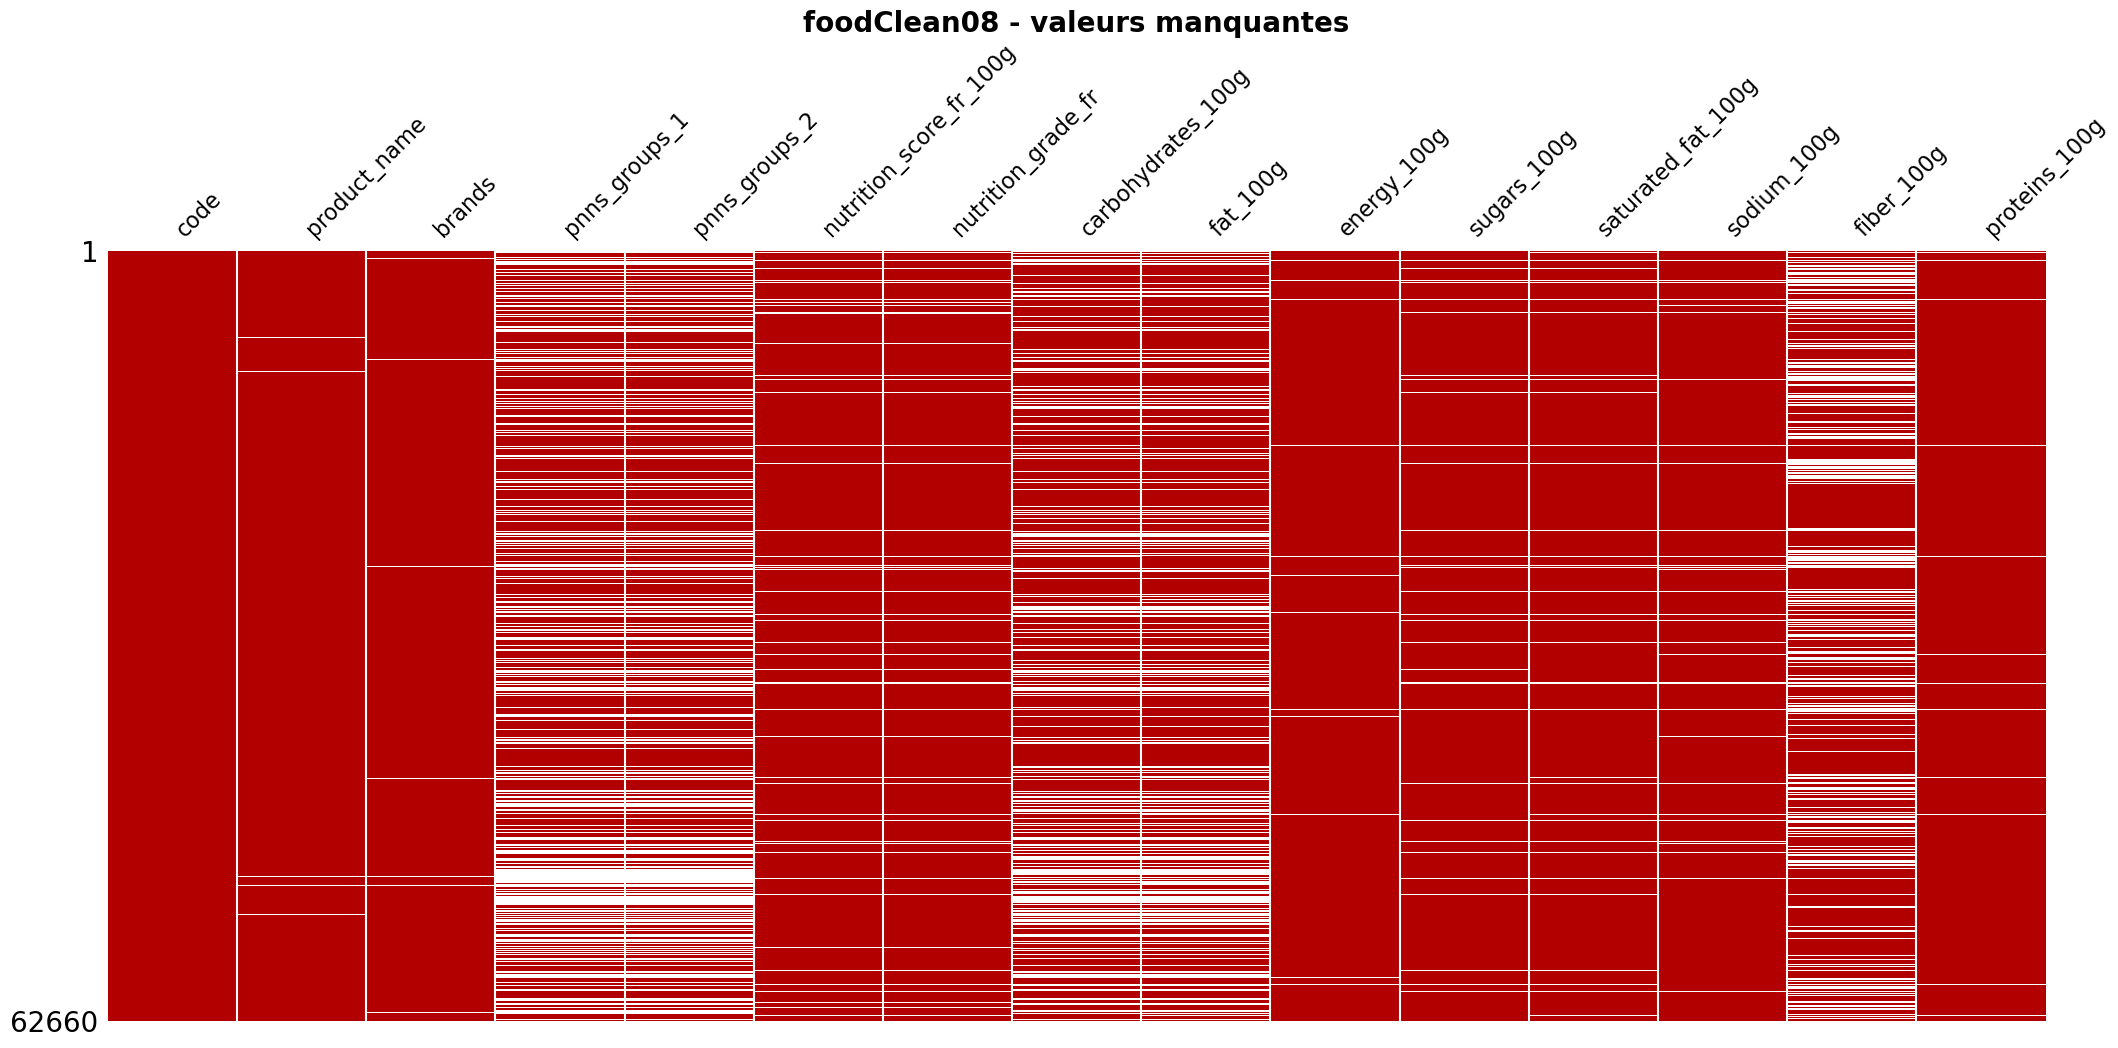

In [34]:
# visualisation
ms.matrix(foodClean08,color=[0.7,0.0,0.0],sparkline=False) # dataviz of missing data
plt.title("foodClean08 - valeurs manquantes",fontweight="bold",fontsize=20) # set legend
plt.show()

### P2.5.2.  Création d'un dataframe de test pour les différentes techniques d'imputation

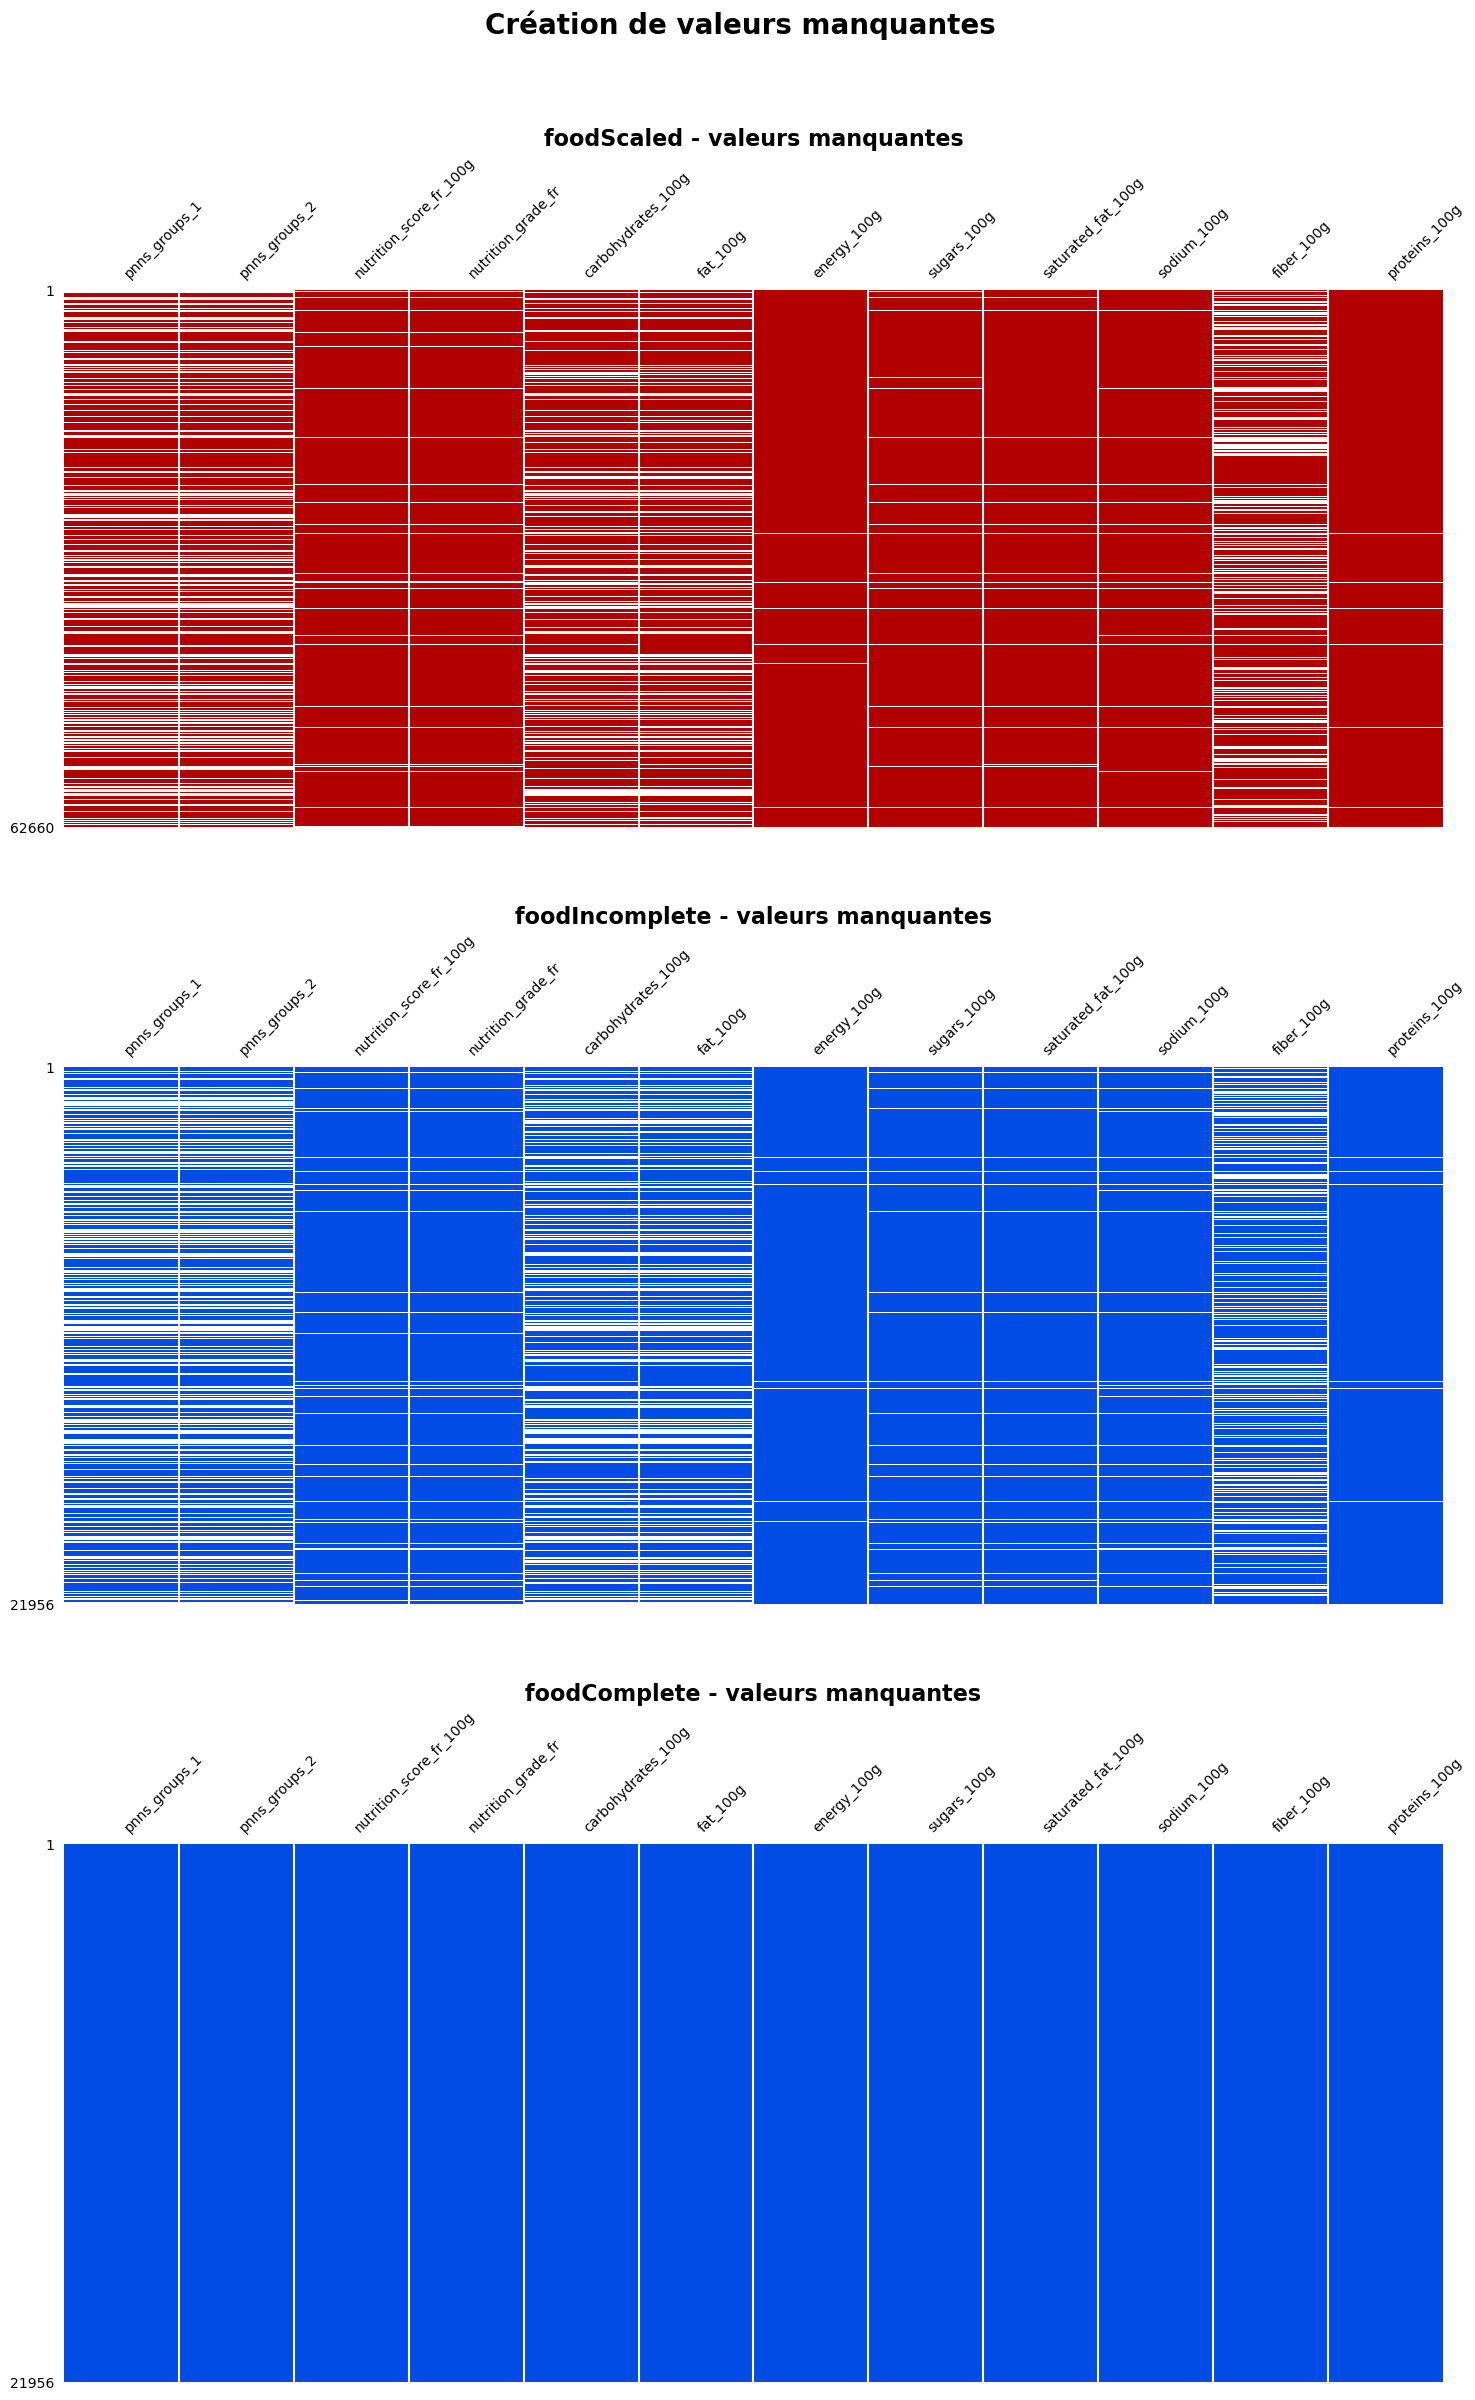

In [35]:
# visualisation of missing values

listOfDf=[foodScaled,foodIncomplete,foodComplete]
listOfDfNames=["foodScaled","foodIncomplete","foodComplete"]
listOfColors=[[0.7,0.0,0.0],[0.0,0.3,0.9],[0.0,0.3,0.9]]

fig,axs=plt.subplots(len(listOfDf),1,figsize=(16,25))
fig.suptitle("Création de valeurs manquantes", fontweight="bold",fontsize=20) # set main title

# dataviz of missing data

for i in range(len(listOfDf)) :
    
    ms.matrix(listOfDf[i],color=listOfColors[i],sparkline=False,ax=axs[i]) 
    axs[i].set_title(listOfDfNames[i]+" - valeurs manquantes", fontweight="bold",fontsize=16) 
    axs[i].set_xticklabels(axs[i].get_xticklabels(),fontsize=10)
    axs[i].set_yticklabels(axs[i].get_yticklabels(),fontsize=10)
    
fig.tight_layout(pad=5.0)

plt.show()

### P2.5.2.  Imputation des features catégorielles

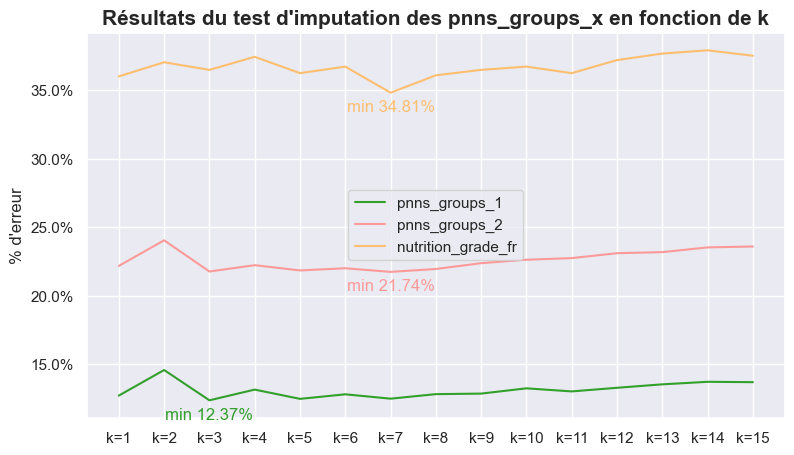

In [36]:
# plot imputation error percentages for different k, for "pnns_groups_1" and "pnns_groups_2" 

sns.set_theme()
fig,axs=plt.subplots(1,figsize=(9,5))


# draw a lineplot for each pnns
for i,catCol in enumerate(errors.columns.tolist()) :
    sns.lineplot(
        data=errors,
        y=errors[catCol],
        x=errors.index.tolist(),
        ax=axs,
        color=foodPaletteDict[catCol.split("_",1)[1]],
        label=catCol.split("_",1)[1]
    )

    # put the best error percentage on each line
    axs.text(
        x=errors[catCol].idxmin(axis=0),
        y=errors[catCol].min()-0.005,
        s="min "+str(round(errors[catCol].min()*100,2))+"%",
        color=foodPaletteDict[catCol.split("_",1)[1]],
        ha="center",
        va="top"
    )
    

axs.set_ylabel("% d'erreur") # set y label
axs.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1)) # use matplotlib.ticker to format y axis as percent
plt.title("Résultats du test d'imputation des pnns_groups_x en fonction de k", fontweight="bold",fontsize=15) # set title


plt.show()


### P2.5.3.  Imputation des features numériques

#### P2.5.3.1.  Test KNN Imputer sur toutes les features en même temps

In [37]:
ShowResultsNumImputsCHOICES (global5NN_measures,"Global_5NN",dictPalette=foodPaletteDict,singleFigsize=(6,5))

Output()

#### P2.5.3.2.  Test Iterative Imputer sur toutes les features en même temps

In [38]:
foodMeasuresTabs=[
    global5NN_measures,
    globalIterImp_measures
]
foodTestNames=[
    "Global_5NN",
    "Global_IterativeImputer"
]

ShowResultsNumImputsCHOICES (foodMeasuresTabs,foodTestNames,dictPalette=foodPaletteDict,singleFigsize=(6,5))

Output()

#### P2.5.3.3.  Test Iterative Imputer sur des groupes précis de features

Analyse bivariée - matrice des corrélations :

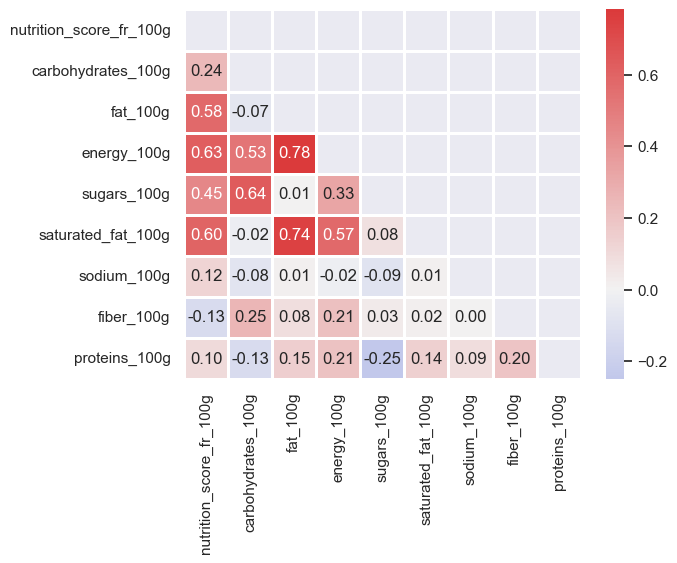

In [39]:
# Compute the correlation matrix
foodCorr=foodCatImputed.loc[~foodCatImputed.isna().all(axis=1)].corr()

# Display the correlation matrix on a heatmap

# Generate a mask to display only the lower triangle
maskTri = np.triu(np.ones_like(foodCorr, dtype=bool),k=0)

# Draw the heatmap with the mask

sns.heatmap(
    data=foodCorr, # use the correlation matrix computed above
    mask=maskTri, # mask to display only the low triangle
    linewidth=1, # line between squares of the heatmap
    cmap=sns.diverging_palette(262,12, as_cmap=True,center="light",n=9), # blue for anticorrelated, red for correlated
    center=0, # no color for no correlation
    annot=True, # displays Pearson coefficients
    fmt="0.2f" # with 2 decimals
);

In [40]:
foodMeasuresTabs=[
    global5NN_measures,
    globalIterImp_measures,
    focusIterImp_measures
]
foodTestNames=[
    "Global_5NN",
    "Global_IterativeImputer",
    "Focus_IterativeImputer"
]

ShowResultsNumImputsCHOICES (foodMeasuresTabs,foodTestNames,dictPalette=foodPaletteDict,singleFigsize=(6,5))

Output()

### P2.5.4.  Résultat des opérations d'imputation

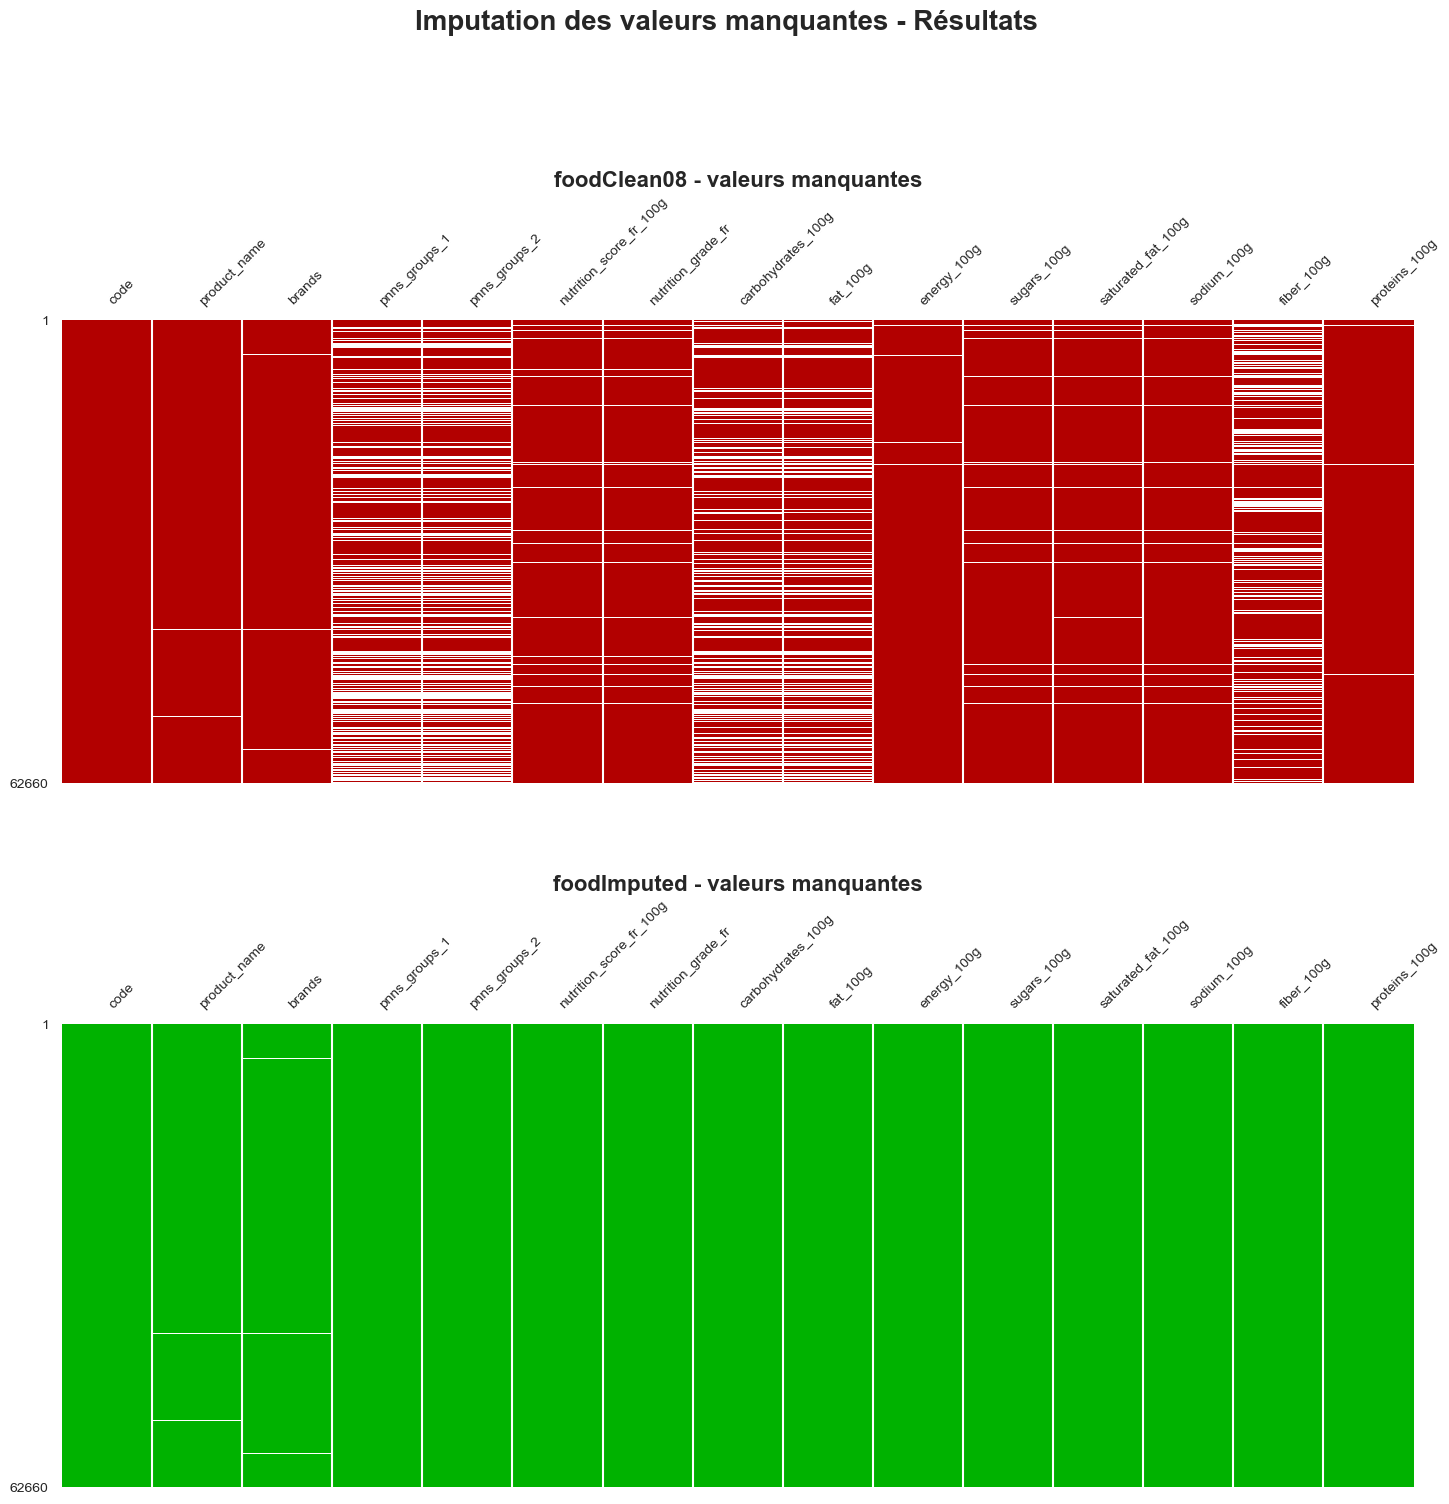

In [41]:
# visualisation of missing values

listOfDf=[foodClean08,foodImputed]
listOfDfNames=["foodClean08","foodImputed"]
listOfColors=[[0.7,0.0,0.0],[0.0,0.7,0.0]]

fig,axs=plt.subplots(len(listOfDf),1,figsize=(16,16))
fig.suptitle("Imputation des valeurs manquantes - Résultats", fontweight="bold",fontsize=20) # set main title

# dataviz of missing data

for i in range(len(listOfDf)) :
    
    ms.matrix(listOfDf[i],color=listOfColors[i],sparkline=False,ax=axs[i]) 
    axs[i].set_title(listOfDfNames[i]+" - valeurs manquantes", fontweight="bold",fontsize=16) 
    axs[i].set_xticklabels(axs[i].get_xticklabels(),fontsize=10)
    axs[i].set_yticklabels(axs[i].get_yticklabels(),fontsize=10)
    
fig.tight_layout(pad=5.0)

plt.show()

# Partie 3 - Exploration

## P3.1. Analyses univariées

In [42]:
myDescribe(food)

RadioButtons(description='Which features :', options=('quantitative', 'qualitative', 'all'), style=Description…

Output()

In [43]:
foodColList = food.columns.tolist()
foodColList.remove("code")
foodColList.remove("product_name")
foodColList.remove("brands")

compareDfDistribs(newDf=food,oldDf=foodClean08,colList=foodColList,dictPalette=foodPaletteDict)

Dropdown(description='Feature :', options=('pnns_groups_1', 'pnns_groups_2', 'nutrition_score_fr_100g', 'nutri…

Output()

## P3.2. Analyse bivariée - ANOVA sur `'nutrition_score_fr_100g ~ pnns_groups_1'`

Postulats :
- les **distributions des résiduels** associées à chaque modalité de "pnns_groups_1" sont **normales**
- ces distributions ont la **même variance**
- les **données** de chaque distributions **sont indépendantes**

Hypothèses :
- **H0 : les distributions sont similaires** (leurs moyennes empiriques sont identiques)
- **H1 : au moins une distribution est différente**

### P3.2.1. ANOVA - premier essai

#### Vérification postulats - normalité

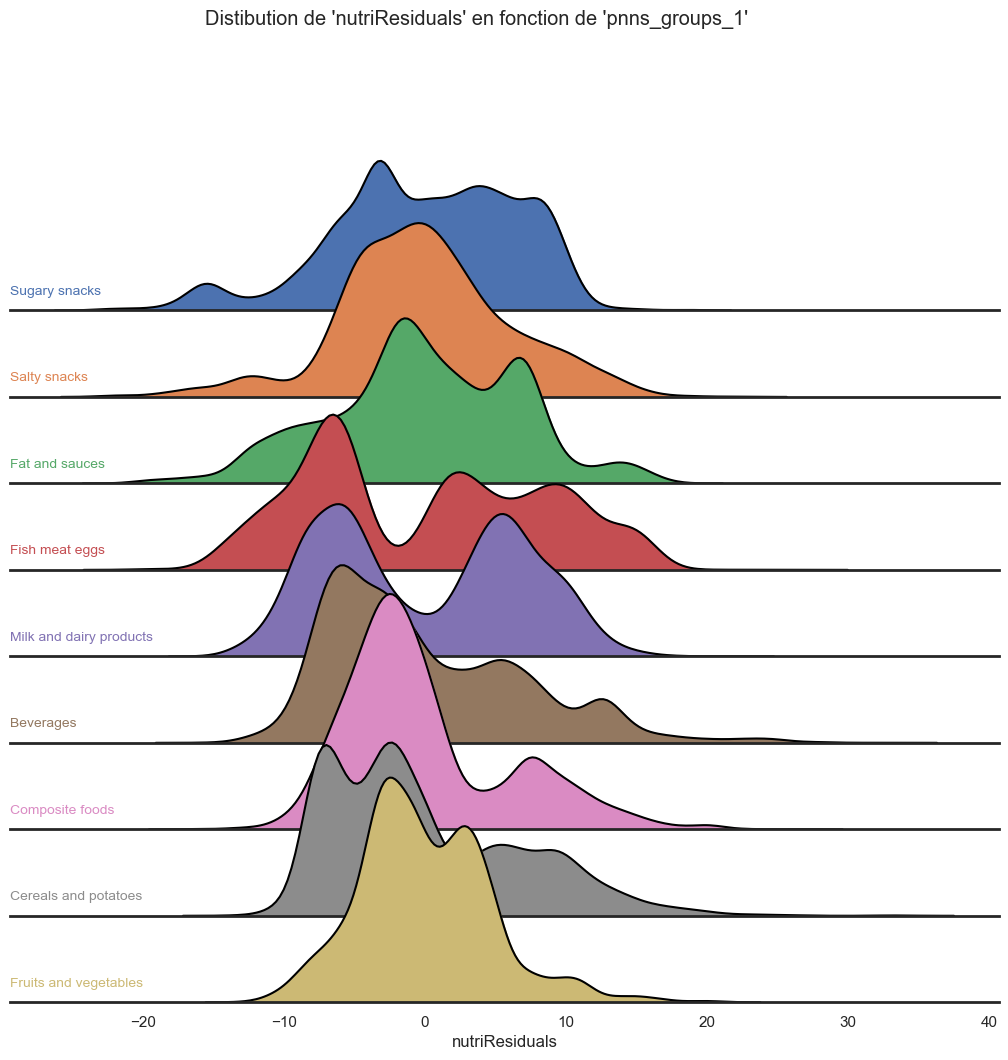

In [44]:
foodAnova,foodAnovaTable = myOneWayAnova (
    df=food,
    categFeatureName="pnns_groups_1",
    numFeatureName="nutrition_score_fr_100g",
    alpha=0.05)

# create a dataframe with residuals of our ANOVA
foodResiduals=food[["pnns_groups_1"]].copy()
foodResiduals["nutriResiduals"]=foodAnova.resid

# plot density plots for "nutriResiduals", for each "pnns_groups_1" label

# set order
myOrder = food.groupby("pnns_groups_1")["nutrition_score_fr_100g"].median().sort_values(ascending=False).index.tolist()

# plot using the distribRidgePlot function
distribRidgePlot(
    df=foodResiduals, 
    categFeatureName="pnns_groups_1", 
    numFeatureName="nutriResiduals",
    order=myOrder,
    overlap=0.65)

#### Vérification postulats - homogénéité variances

In [45]:
varByPnns1=foodResiduals.groupby("pnns_groups_1").var()
varByPnns1.rename(columns={"nutriResiduals":"Nutri_variance"},inplace=True)
varByPnns1

Nutri_variance
pnns_groups_1                          
Beverages                     48.889357
Cereals and potatoes          45.983866
Composite foods               34.551479
Fat and sauces                44.081449
Fish meat eggs                70.681261
Fruits and vegetables         21.894182
Milk and dairy products       48.738368
Salty snacks                  37.122010
Sugary snacks                 43.132819

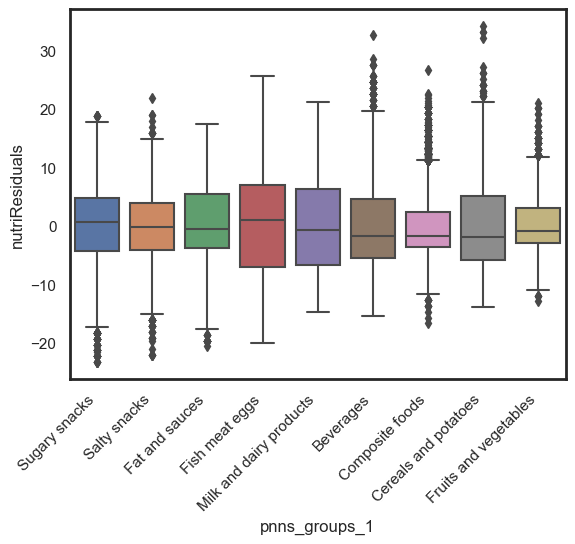

In [46]:
fig,ax = plt.subplots(1)

sns.boxplot(data=foodResiduals,
            x="pnns_groups_1",
            y="nutriResiduals",
            ax=ax,
            order=myOrder)
ax.set_xticklabels(myOrder,
                   rotation=45,
                  ha="right",
                  va='top')
plt.show()

In [47]:
stats.levene(food.loc[food["pnns_groups_1"]=='Sugary snacks','nutrition_score_fr_100g'],
             food.loc[food["pnns_groups_1"]=='Cereals and potatoes','nutrition_score_fr_100g'],
             food.loc[food["pnns_groups_1"]=='Beverages','nutrition_score_fr_100g'],
             food.loc[food["pnns_groups_1"]=='Composite foods','nutrition_score_fr_100g'],
             food.loc[food["pnns_groups_1"]=='Fruits and vegetables','nutrition_score_fr_100g'],
             food.loc[food["pnns_groups_1"]=='Fish meat eggs','nutrition_score_fr_100g'],
             food.loc[food["pnns_groups_1"]=='Milk and dairy products','nutrition_score_fr_100g'],
             food.loc[food["pnns_groups_1"]=='Salty snacks','nutrition_score_fr_100g'],
             food.loc[food["pnns_groups_1"]=='Fat and sauces','nutrition_score_fr_100g'],
            )

LeveneResult(statistic=461.83119623299456, pvalue=0.0)

### P3.2.2. ANOVA - second essai

#### Échantillonage pour avoir des tailles de groupes homogènes - impact sur les distributions ?

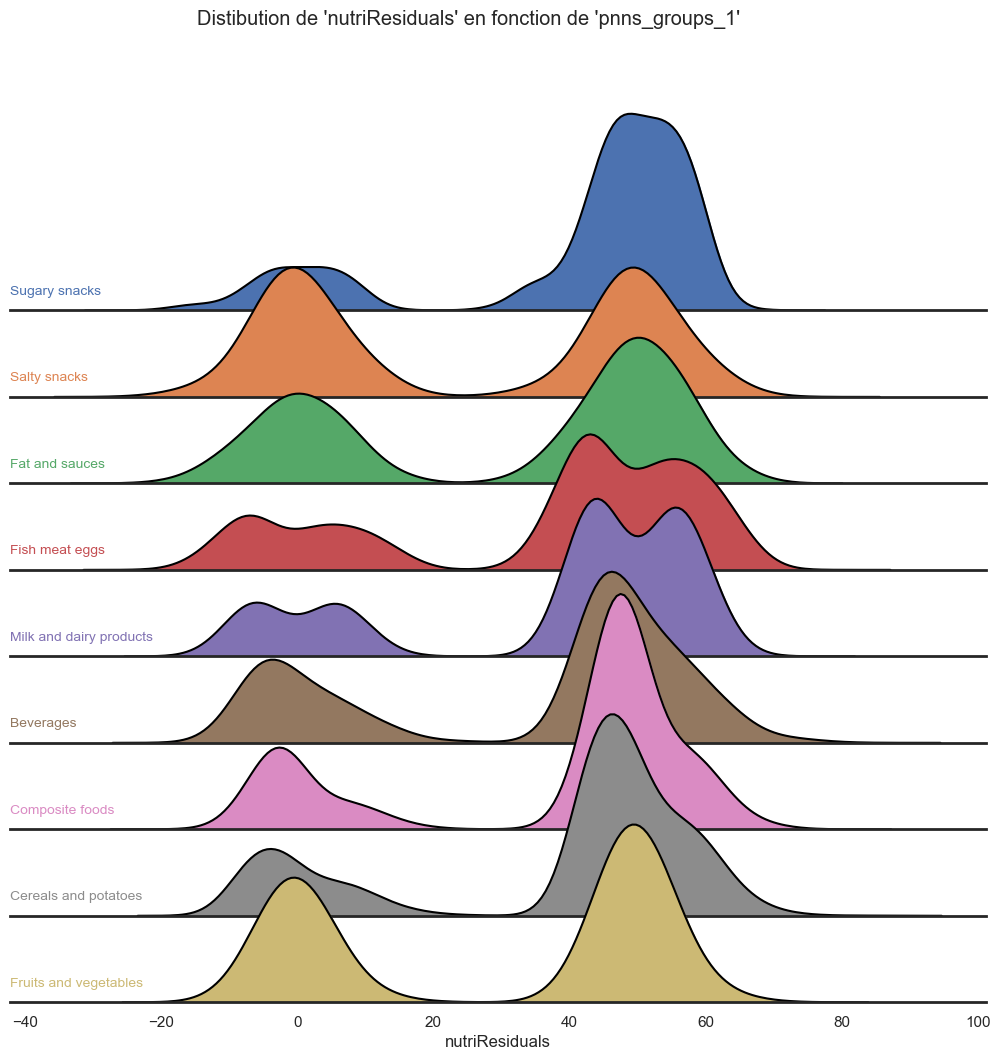

In [48]:
# create a specific dataframe for ANOVA test on "pnns_groups_1"~"nutrition_score_fr_100g"

# store the minimum size of "pnns_groups_1"
groupSize=food.groupby("pnns_groups_1")["nutrition_score_fr_100g"].count().min()

# choose random samples of our dataframe based on "pnns_groups_1" labels, each with same size
foodForAnova=pd.DataFrame()
for cat1 in food["pnns_groups_1"].unique() :
    foodForAnova=pd.concat([
        foodForAnova,
        food.loc[food["pnns_groups_1"]==cat1,["pnns_groups_1","nutrition_score_fr_100g"]].sample(n=groupSize)
    ])

foodForAnova=foodForAnova.sort_index()

# ANOVA BIS
foodAnovaBIS,foodAnovaTableBIS = myOneWayAnova (
    df=foodForAnova,
    categFeatureName="pnns_groups_1",
    numFeatureName="nutrition_score_fr_100g",
    alpha=0.05)

# create a dataframe with residuals of our ANOVA
foodResidualsBIS=foodForAnova[["pnns_groups_1"]].copy()
foodResidualsBIS["nutriResiduals"]=foodAnovaBIS.resid

# create a dataframe with values of both residuals to compare distributions shapes
compareShape=foodResiduals.copy()
compareShape["nutriResiduals"]=compareShape["nutriResiduals"]+50 # create an offset on values of our first residuals
compareShape=pd.concat([compareShape,foodResidualsBIS],axis=0).reset_index() # concatenate both dataframes

# display distributions
distribRidgePlot(
    df=compareShape, 
    categFeatureName="pnns_groups_1", 
    numFeatureName="nutriResiduals",
    order=myOrder,
    overlap=0.65)

### P3.2.3. ANOVA - interprétation

In [49]:
# display one-way ANOVA table for "nutrition_score_fr_100g ~ pnns_groups_1"
foodAnovaTableBIS

Sum_of_Squares  Degrees_Freedom    Mean_Square  F_statistic  \
Model             8.472791e+05              8.0  105909.886851  2420.690571   
Residual_Error    1.128537e+06          25794.0      43.751931          NaN   
Total             1.975816e+06          25802.0            NaN          NaN   

                Critical_F  F_test_p_value  Eta_Square  
Model             1.938771             0.0    0.428825  
Residual_Error         NaN             NaN         NaN  
Total                  NaN             NaN         NaN

## P3.3. Analyse multivariée - ACP

In [50]:
# select numerical features for PCA
pcaColNames=food.select_dtypes("float64").columns.tolist()
pcaColNames.remove("nutrition_score_fr_100g")
pcaColNames

# use myPCA function
%time X_scaled, Xidx, Xfeat, foodPCA = myPCA (df=food,q=6,ACPfeatures=pcaColNames)

Wall time: 66.9 ms


### P3.3.1. ACP - Part de dispersion expliquée

In [51]:
PCA_scree_plot(foodPCA)

### P3.3.2. ACP - corrélations composantes / variables initiales

In [52]:
heatPcaCorrelationMatrixWid (df=food,
                                 X_scaled=X_scaled,
                                 pca=foodPCA,  
                                 PcafeaturesNames=Xfeat,
                                 figsize=(12,5)
                                )

Dropdown(description='Additionnal variable :', options={'nutrition_score_fr_100g': (array([[ 1.51093894,  0.39…

Output()

### P3.3.3. ACP - cercle des corrélations

In [53]:
correlation_graph_enhanced_WID(df=food,
                               X_scaled=X_scaled,
                               pca=foodPCA,  
                               PcafeaturesNames=Xfeat,
                               dictPalette=foodPaletteDict,
                               figsize=(7,7),
                               )

Output()

In [54]:
cos2=pcaCorrelationMatrix (foodPCA,
                          Xfeat,
                          additionnalVariable=None
                          )**2
cos2

F1 (32.2%)  F2 (23.1%)  F3 (14.8%)  F4 (12.1%)  F5 (9.1%)  \
carbohydrates_100g    0.174251    0.650724    0.034376    0.005321   0.026380   
fat_100g              0.696606    0.177123    0.034002    0.000080   0.021797   
energy_100g           0.903193    0.004676    0.004391    0.000055   0.005676   
sugars_100g           0.138553    0.592873    0.027389    0.023602   0.019361   
saturated_fat_100g    0.587832    0.139966    0.057015    0.000054   0.013269   
sodium_100g           0.000874    0.044151    0.071135    0.877701   0.006141   
fiber_100g            0.036650    0.030565    0.594277    0.045824   0.277004   
proteins_100g         0.039124    0.206615    0.358960    0.014979   0.360690   

                    F6 (5.2%)  
carbohydrates_100g   0.044922  
fat_100g             0.016676  
energy_100g          0.066766  
sugars_100g          0.147698  
saturated_fat_100g   0.105204  
sodium_100g          0.000009  
fiber_100g           0.014492  
proteins_100g        0.018570

### P3.3.4. ACP - Projection sur plans principaux

brute :

In [55]:
def proj_on_principal_planes(   X_projected, 
                                x_y, 
                                pca=None, 
                                labels = None,
                                clusters=None, 
                                alpha=1,
                                figsize=[10,8], 
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments : 
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments : 
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8] 
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """
    
    sns.set_theme()
    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize: 
        figsize = (7,6)

    # On gère les labels
    if  labels is None : 
        labels = []
    try : 
        len(labels)
    except Exception as e : 
        raise e

    # On vérifie la variable axis 
    if not len(x_y) ==2 : 
        raise AttributeError("2 axes sont demandées")   
    if max(x_y )>= X_.shape[1] : 
        raise AttributeError("la variable axis n'est pas bonne")   

    # on définit x et y 
    x, y = x_y

    # Initialisation de la figure       
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters
 
    # Les points    
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha, 
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe 
    if pca : 
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else : 
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y 
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) : 
        # j'ai copié collé la fonction sans la lire
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='14', ha='center',va='center') 

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.axis('scaled') 
    plt.show()


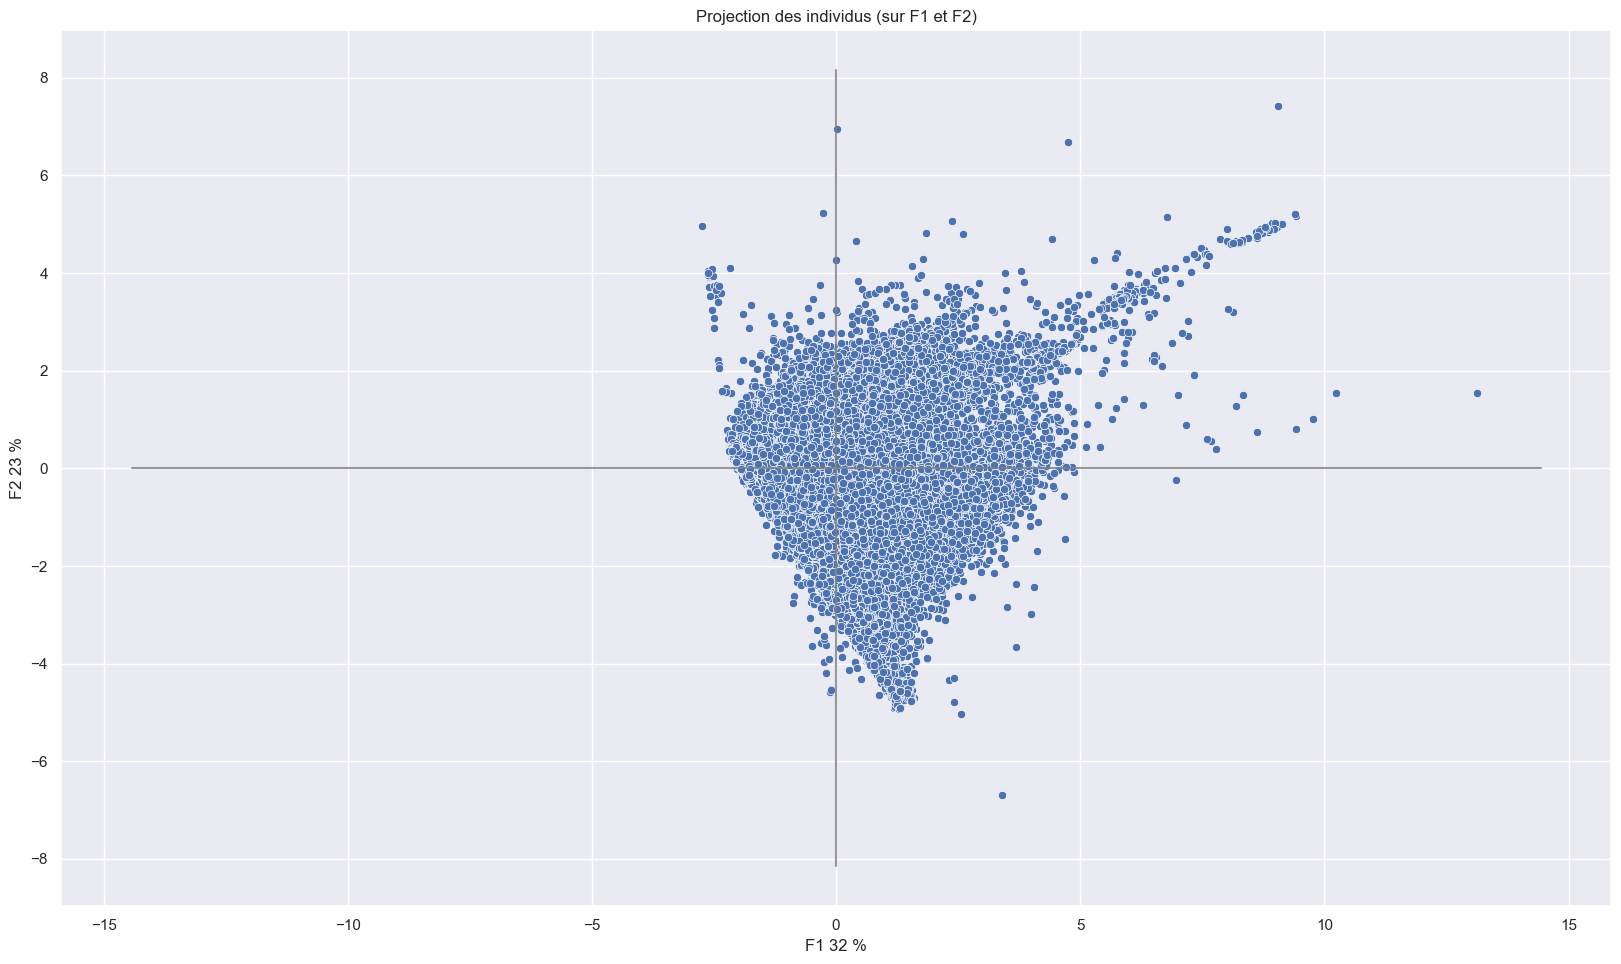

In [56]:
proj_on_principal_planes(
    X_projected=foodPCA.transform(X_scaled), 
    x_y=[0,1], 
    pca=foodPCA, 
    labels=None, 
    figsize=(20,16), 
    clusters=None, 
    marker="o"
)

avec un code couleur par catégorie de "pnns_groups_1" :

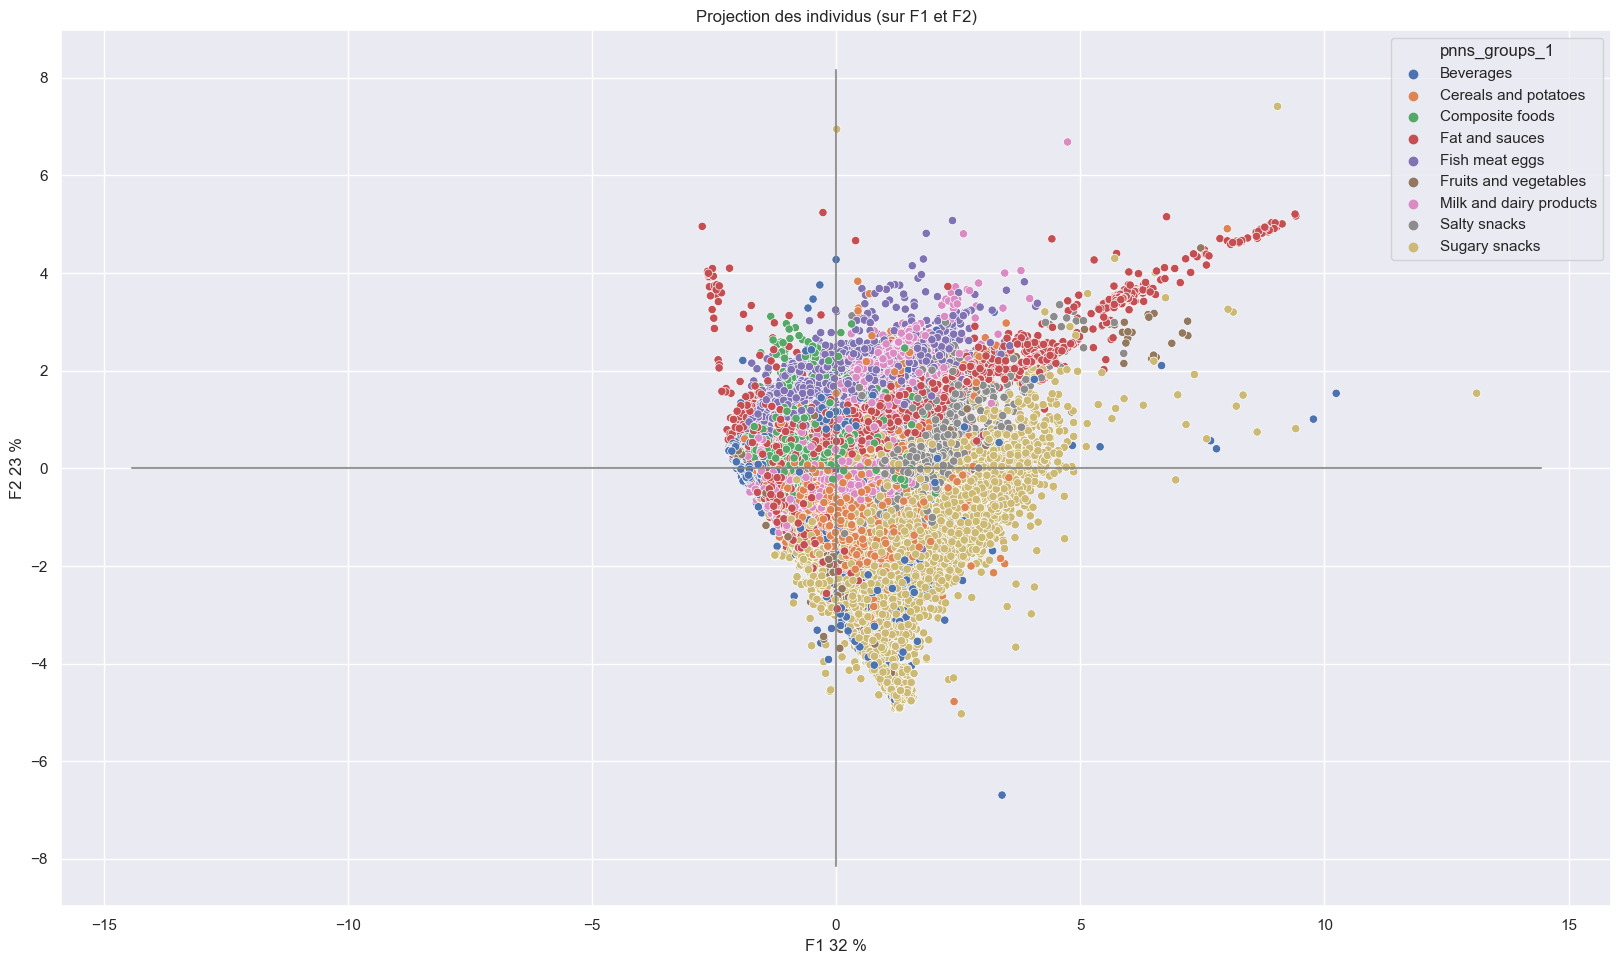

In [57]:
proj_on_principal_planes(
    X_projected=foodPCA.transform(X_scaled), 
    x_y=[0,1], 
    pca=foodPCA, 
    labels=None, 
    figsize=(20,16), 
    clusters=food["pnns_groups_1"], 
    marker="o"
)

# Partie 4 - Résultats

## Comment se répartissent nos produits ? distributions de "pnns_groups_1" ou "pnns_groups_2" le long de nos composantes

In [58]:

# create a dataframe with orignial cateorical columns of food and our "nutrition_score_fr_100g" and principal components as numerical columns
foodComp=pd.concat(
    [
        food[[col for col in food.columns if col not in Xfeat]],
        pd.DataFrame(
            foodPCA.transform(X_scaled),
            index=Xidx,
            columns=["F"+str(i+1) for i in range(foodPCA.n_components_)])
    ],
    axis=1
)


# use the displayByIntervalWID function
displayByIntervalWID (foodComp,palette=foodPaletteDict)

GridBox(children=(ToggleButtons(button_style='info', description='Numerical variable      :', layout=Layout(gr…

Output()